In [1]:
%%time 
import pandas as pd
from pandas.tseries.offsets import MonthEnd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
import bluesquare_data_pipelines.access as blsq
import geopandas as gpd
from shapely.geometry import Point


pdss= blsq.dhis_instance("local_pdss")
snis= blsq.dhis_instance("dhis2_drc_snis_replica")

snis_pdss_map = pd.read_csv("/Users/grlurton/Documents/data/rdc/pdss_snis_mapping/mapping_pdss_snis.csv")
%matplotlib inline

Connected we are
Getting Orgunits
Getting Data Elements
Getting Data Element Groups
Getting Orgunits Pyramid
Getting Category Option Combos
Getting Periods
Connected we are
Getting Orgunits
Getting Data Elements
Getting Data Element Groups
Getting Orgunits Pyramid
Getting Category Option Combos
Getting Periods
CPU times: user 1.43 s, sys: 449 ms, total: 1.88 s
Wall time: 14.6 s


In [2]:
def select_fosa(data, prop, start_date, end_date, exclude_periods = np.nan):
    n_months = pd.date_range(start = pd.to_datetime(start_date,  format='%Y%m'), end = pd.to_datetime(end_date,  format='%Y%m'), freq="M").nunique()
    if ((len(data) > prop*n_months) & (min(data.monthly) == start_date)):
        return data
    
def fill_missing_covariates(data, list_variables):
    data[list_variables] = data[list_variables].fillna(method="ffill")
    return data

def make_interpolated_dataset(data, start_date, end_date):
    data.monthly = pd.to_datetime(data.monthly,  format='%Y%m') + MonthEnd(1)
    date_list = pd.date_range(start = pd.to_datetime(start_date,  format='%Y%m'), end = pd.to_datetime(end_date,  format='%Y%m'), freq="M").tolist()*len(data.uidorgunit.unique())
    fosa_list = sorted(data.uidorgunit.unique().tolist()*len(set(date_list)))
    expectation = pd.DataFrame({"monthly":date_list, "uidorgunit":fosa_list})
    full_dat = data.merge(expectation, how="right")
    full_dat = full_dat.groupby("uidorgunit").apply(fill_missing_covariates,["uidlevel3","uidlevel2","dataelementid","dataelementname","catcomboid","catcomboname"])
    full_dat = full_dat.set_index(["uidlevel2","uidorgunit","monthly"]).groupby(level=0).value.apply(lambda x : x.interpolate())
    return full_dat

In [3]:
%%capture
%%time
pdss_defs = ['Acceptante nouvelle et renouvellement \(DIU et implant\) - Ver', 'Acceptante nouvelle et renouvellement \(oral & inj\) - Ver', 
             'Enfant complètement vacciné - Ver', 
             'Accouchement assisté - Ver',
             'Consultation Prénatale 4ème visite - Ver', 'Consultation Prénatale 1ère visite - Ver',
             'Consultation Postnatale - Ver',
             ' Consultation externe \(nvx cas\)-ver', 'Consultation Externe \(nvx cas patient indigent\) - plafond 5% - Ver']


snis_defs = ["A 1.4 Cas suspect",
             "A 1.4 TDR réalisé", "A 1.4 TDR positif",
             "A 1.4 Paludisme simple confirmé", "A 1.4 Paludisme simple confirmé traité [PN]", 
             "A 1.4 Paludisme présumé", "A 1.4 Paludisme présumé traité", 
             "A 1.4 Paludisme grave", "A 1.4 Paludisme grave traité",
             "A 2.1 CPN 1", "A 2.1 CPN 4", "A 2.1 CPN 2", "A 2.1 CPN 3",
             "A 2.1 CPN 4 à la 36ème semaine", "A 2.1 CPN 1 à la 16ème semaine",
             'A 2.3 Accouchements par personnel qualifié', "A 2.3 Accouchement",
             "A 2.3 Accouchées référées l'HGR",
             "A 2.6 CPoN1 (6ème heure)", "A 2.6 CPoN2 (6ème jour)", "A 2.6 CPoN3 (42ème jour)",
             "A 3.1 Nouvelle acceptante PF (total)",
             "A 4.4 Recettes paiement direct", "A 4.4 Recettes tiers payant (FBR, Mutuelle et autres)", 
             "A 4.4 Autres subsides", "A 4.4 Autres recettes",
             "A 4.6 Salaire de l'Etat", "A 4.6 Prime de l'Etat"]
             
## Take out uselesses
## Add in n walkins
## standardize average consultation cost

pdss_ids = pdss.dataelement.uid[pdss.dataelement.name.isin(pdss_defs)]
snis_ids = snis.dataelement.uid[snis.dataelement.name.isin(snis_defs)]

pdss_extract = pdss.get_data(pdss_ids, pdss.organisationunit.uid,)
snis_extract = snis.get_data(snis_ids, snis.organisationunit.uid)

In [4]:
%%time
pdss_extract.dataelementname = pdss_extract.dataelementname.str.lower()
pdss_extract = pdss_extract[(pdss_extract.monthly < "201901") & (pdss_extract.monthly >= "201701")] # & ~(pdss_extract.monthly.isin(["201703","201704"]))]
pdss_extract.value = pdss_extract.value.astype(float)
print("N values in PDSS :" + str(len(pdss_extract)))

snis_extract.dataelementname = snis_extract.dataelementname.str.lower()
snis_extract = snis_extract[(snis_extract.monthly < "201901") & (snis_extract.monthly >= "201701")]
snis_extract.value = snis_extract.value.astype(float)
print("N values in SNIS :" + str(len(snis_extract)))

N values in PDSS :204989
N values in SNIS :9311890
CPU times: user 35.5 s, sys: 2min 31s, total: 3min 7s
Wall time: 4min 10s


## Financial Data Description

### Amounts paid

* Normalize value by activity
* Imputation

In [5]:
%%time
financial_data = snis_extract[snis_extract.dataelementname.str.contains("recettes|subsides|salaire|prime")]
financial_data_complete = financial_data.groupby("uidorgunit").apply(select_fosa, .8, "201701","201901")

CPU times: user 1min 1s, sys: 1min 52s, total: 2min 53s
Wall time: 3min 39s


While selecting facilities with at least 80% completeness on financial data, we have to drop 37% of the facilities in the system, which make up for 22% of the data being reported on facilities incomes.

In [6]:
%%time
print("% data dropped : " + str(100 - np.round(100*len(financial_data_complete) / len(financial_data), 1)) + "%")
print("% FOSA dropped : " + str(100 - np.round(100 * financial_data_complete.uidorgunit.nunique() / financial_data.uidorgunit.nunique(),1)) + "%")

% data dropped : 21.599999999999994%
% FOSA dropped : 36.8%
CPU times: user 937 ms, sys: 312 ms, total: 1.25 s
Wall time: 1.65 s


/anaconda3/envs/geo_env/lib/python3.7/site-packages/pandas/core/generic.py:5096: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value
/anaconda3/envs/geo_env/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


CPU times: user 7.25 s, sys: 25 s, total: 32.2 s
Wall time: 42.1 s


Text(0.5, 1.0, 'Total Amout of OOP payments by Province')

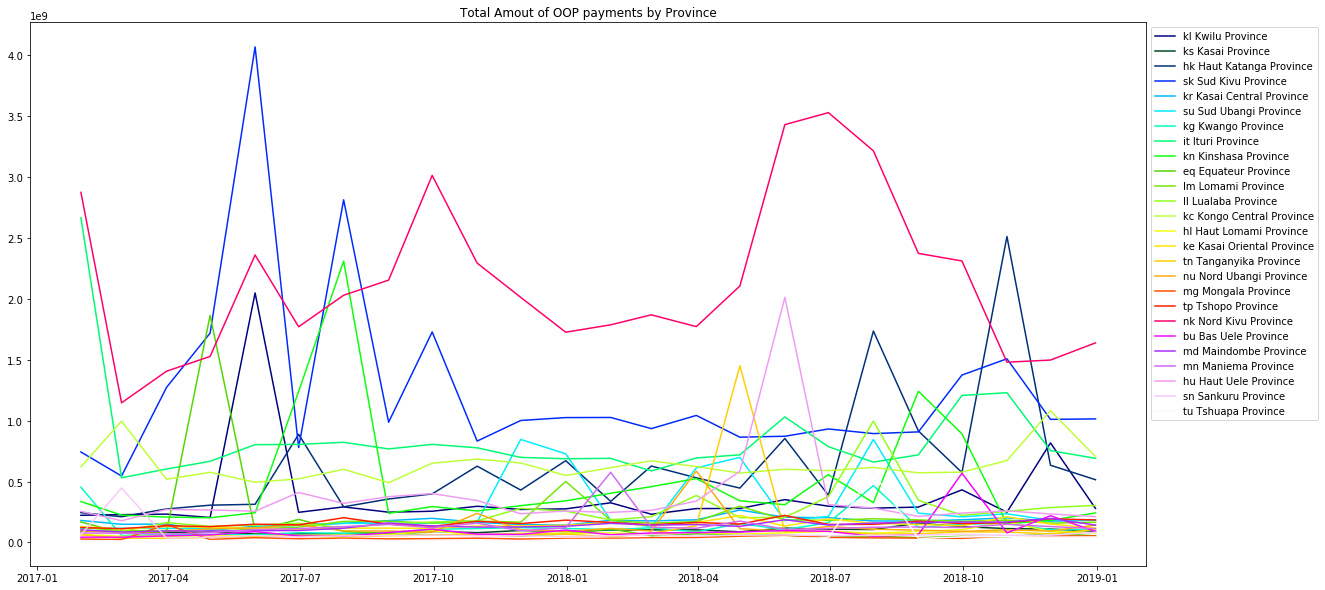

In [7]:
%%time
evolution_payments = financial_data_complete.groupby(["uidlevel2", "enddate", "dataelementname"]).value.sum().reset_index()
evolution_payments = evolution_payments.merge(snis.organisationunit[["uid","name"]], left_on="uidlevel2", right_on="uid")

dat = evolution_payments[evolution_payments.dataelementname.str.contains("paiement direct")]
plt.figure(figsize=(20,10))
cmap = plt.cm.gist_ncar(np.linspace(0, 1, dat.name.nunique()))
i = 0
for province in dat.name.unique():
    datp=dat[dat.name == province]
    datp.enddate = pd.to_datetime(datp.enddate)
    plt.plot(datp.enddate, datp.value, label = province, c = cmap[i])
    plt.legend(bbox_to_anchor = [1,1])
    i = i + 1
plt.title("Total Amout of OOP payments by Province")

CPU times: user 1.82 s, sys: 1.25 s, total: 3.08 s
Wall time: 3.31 s


Text(0.5, 1.0, 'Average per-FOSA amount of OOP payment')

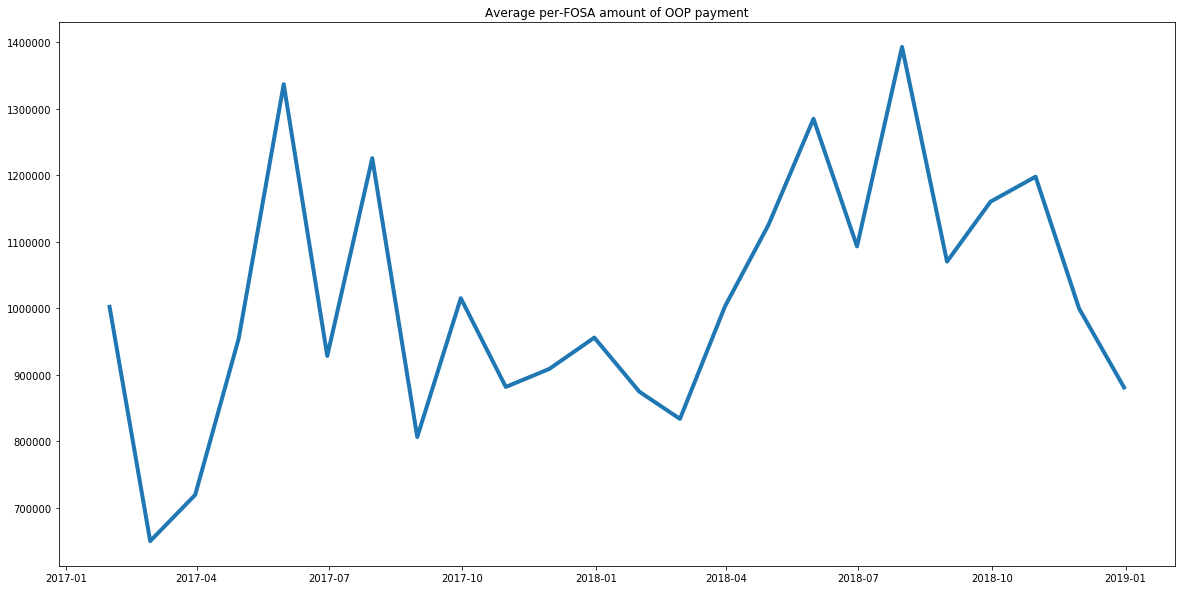

In [8]:
%%time
payments_fosa = financial_data_complete[financial_data_complete.dataelementname.str.contains("paiement direct")]

nat = payments_fosa.groupby("enddate").apply(lambda x: x.value.sum() / len(x.uidorgunit.unique())).reset_index()
nat.enddate = pd.to_datetime(nat.enddate)
nat.columns = ["enddate", "value"]

plt.figure(figsize=(20,10))
plt.plot(nat.enddate, nat.value, linewidth = 4)
plt.title("Average per-FOSA amount of OOP payment")

CPU times: user 9.08 s, sys: 10.6 s, total: 19.7 s
Wall time: 23.7 s


(0, 0.9)

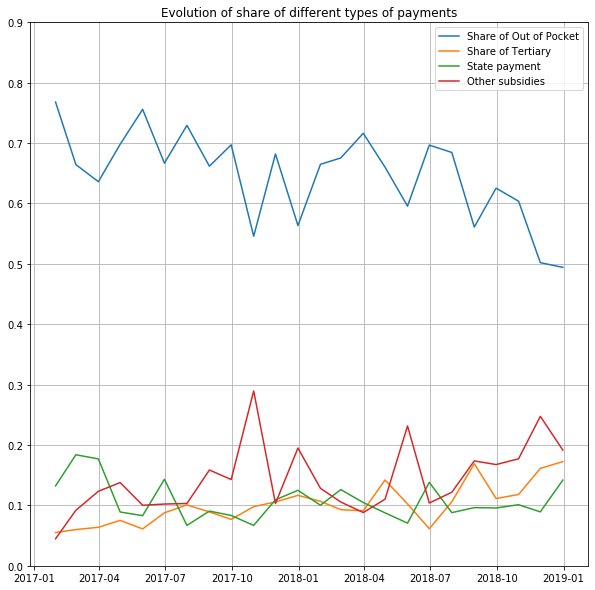

In [9]:
%%time
budget = ["recettes paiement direct", "recettes tiers payant",  "autres recettes", 
          "salaire de l'etat", "autres subsides", "prime de l'etat"]
budget_data = financial_data_complete[financial_data_complete.dataelementname.str.contains('|'.join(budget))]

def share_budget(data):
    total = data.value.sum()
    share_oop = (data.value[data.dataelementname.str.contains("recettes paiement direct")].sum() + data.value[data.dataelementname.str.contains("autres recettes")].sum()) / total
    share_tertiary = data.value[data.dataelementname.str.contains("recettes tiers payant")].sum() / total
    state_payment = data.value[data.dataelementname.str.contains("salaire de l'etat|prime de l'etat")].sum() / total
    other_subsidies = data.value[data.dataelementname.str.contains("autres subsides")].sum() / total
    return pd.DataFrame({'total':[total], "share_oop":[share_oop], "other_subsidies":other_subsidies, 
                         "share_tertiary":[share_tertiary], "state_payment":state_payment})

evol_budget = budget_data.groupby("enddate").apply(share_budget).reset_index()

plt.figure(figsize= (10,10))
plt.plot(evol_budget.enddate, evol_budget.share_oop, label = "Share of Out of Pocket")
plt.plot(evol_budget.enddate, evol_budget.share_tertiary, label = "Share of Tertiary")
plt.plot(evol_budget.enddate, evol_budget.state_payment, label = "State payment")
plt.plot(evol_budget.enddate, evol_budget.other_subsidies, label = "Other subsidies")
plt.legend(bbox_to_anchor = [1,1])
plt.legend(bbox_to_anchor = [1,1])
plt.title("Evolution of share of different types of payments")
plt.yticks(np.arange(0, 1, step=0.1))
plt.grid()
plt.ylim((0,.9))

CPU times: user 25.2 s, sys: 41.1 s, total: 1min 6s
Wall time: 1min 24s


(0, 0.9)

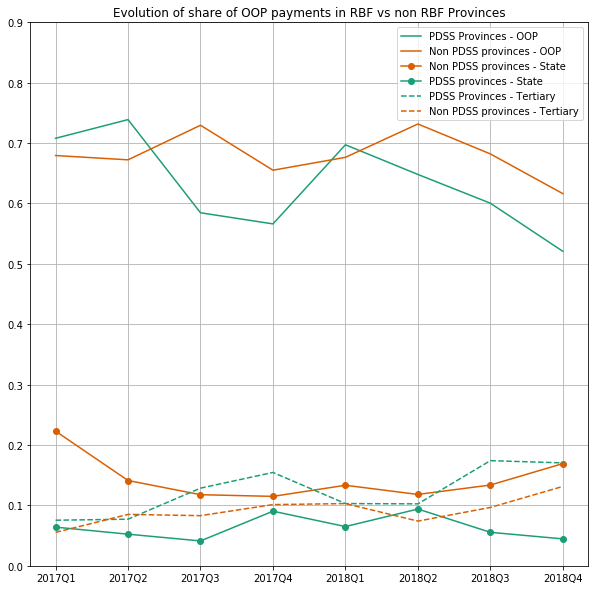

In [10]:
%%time
share_province = budget_data.groupby(["enddate", "uidlevel2"]).apply(share_budget).reset_index().merge(snis.organisationunit[["uid","name"]], left_on="uidlevel2", right_on="uid")
pdss_provinces = share_province.uidlevel2[share_province.name.str.contains('|'.join(["eq ","hk ","hl ","ll ","mg ", "mn ","sk ", "nk ", "su ", "tu ", "kg ", "kl "]))].unique().tolist()

pdss_budget = budget_data[(budget_data.uidlevel2.isin(pdss_provinces)) & (budget_data.uidorgunit.isin(snis_pdss_map["SNIS Facility ID"].tolist()))]
non_pdss_budget = budget_data[~ budget_data.uidlevel2.isin(pdss_provinces)& ~(budget_data.uidorgunit.isin(snis_pdss_map["SNIS Facility ID"].tolist()))]

pdss_share = pdss_budget.groupby(["quarterly"]).apply(share_budget).reset_index()
non_pdss_share = non_pdss_budget.groupby(["quarterly"]).apply(share_budget).reset_index()

cmap = mpl.cm.get_cmap('Dark2')
plt.figure(figsize= (10,10))
plt.plot(pdss_share.quarterly, pdss_share.share_oop, label = "PDSS Provinces - OOP", c=cmap(0))
plt.plot(non_pdss_share.quarterly, non_pdss_share.share_oop, label = "Non PDSS provinces - OOP", c=cmap(1))
plt.plot(non_pdss_share.quarterly, non_pdss_share.state_payment, "o-",label = "Non PDSS provinces - State", c=cmap(1))
plt.plot(pdss_share.quarterly, pdss_share.state_payment, "o-" ,label = "PDSS provinces - State", c=cmap(0))
plt.plot(pdss_share.quarterly, pdss_share.share_tertiary, "--", c=cmap(0), label = "PDSS Provinces - Tertiary")
plt.plot(non_pdss_share.quarterly, non_pdss_share.share_tertiary, "--", c=cmap(1), label = "Non PDSS provinces - Tertiary")
plt.legend(bbox_to_anchor = [1,1])
plt.title("Evolution of share of OOP payments in RBF vs non RBF Provinces")
plt.yticks(np.arange(0, 1, step=0.1))
plt.grid()
plt.ylim((0,.9))

## % FOSAs in PDSS by province

In [11]:
%%time
# Computing the % fosa of each province in PDSS 

snis_fosa = snis_extract.groupby("uidlevel2").uidorgunit.apply(lambda x : x.nunique()).reset_index().merge(snis.organisationunit[["uid","name"]], left_on="uidlevel2", right_on="uid")
pdss_fosa = pdss_extract.groupby("uidlevel2").uidorgunit.apply(lambda x : x.nunique()).reset_index().merge(pdss.organisationunit[["uid","name"]], left_on="uidlevel2", right_on="uid")

snis_fosa.name = snis_fosa.name.str.lower()
pdss_fosa.name = pdss_fosa.name.str.lower()
pdss_fosa.name = pdss_fosa.name.str.replace("dps", "province")

snis_pdss_compare = snis_fosa.merge(pdss_fosa, on = "name" , suffixes = ["_snis", "_pdss"]).set_index("name")

snis_pdss_compare.uidorgunit_pdss / snis_pdss_compare.uidorgunit_snis

CPU times: user 6.65 s, sys: 16.2 s, total: 22.8 s
Wall time: 29.8 s


name
kl kwilu province            0.287953
hk haut katanga province     0.102444
sk sud kivu province         0.171544
su sud ubangi province       0.311054
kg kwango province           0.312500
eq equateur province         0.289179
kc kongo central province    0.000725
hl haut lomami province      0.462230
mg mongala province          0.418426
nk nord kivu province        0.115490
md maindombe province        0.352273
tu tshuapa province          0.432184
dtype: float64

## Mapping PDSS extension

In [25]:
contract_data = pd.read_excel("/Users/grlurton/Documents/data/rdc/pdss/contrats_actifs.xlsx")
start_date = contract_data.groupby(["DPS","Date de début :"]).dhis2_id.apply(lambda x : len(x.unique())).reset_index()

def n_fosa_date(data, dates):
    n_fosa = []
    for date in dates:
        n_fosa.append(data.loc[data["Date de début :"] <= date,"dhis2_id"].sum())
    return pd.DataFrame({"n_fosa":n_fosa,
                         "date":dates})
    
province_start = start_date.groupby("DPS").apply(n_fosa_date, ["2017-01-01", "2018-01-01", "2018-12-01"]).reset_index()
province_start.DPS = province_start.DPS.str.lower().str.replace(" dps", " province")

shape_rdc = "/Users/grlurton/Documents/data/rdc/snis/map_polygons.shp"
map_df = gpd.read_file(shape_rdc)
provinces_df = map_df[map_df.org_unit_I.isin(snis.orgunitstructure.uidlevel2).tolist()]

full_carte_sanitaire = pd.read_excel("/Users/grlurton/Documents/data/rdc/carte_sanitaire.xlsx", 1)

splitted_coords = full_carte_sanitaire[~pd.isnull(full_carte_sanitaire.Coordinates)].Coordinates.str.replace("\[|\]","").str.split(",")
geolocs = pd.DataFrame({"long":splitted_coords.apply(lambda x: x[0]),
                        "lat":splitted_coords.apply(lambda x: x[1]), 
                        "id":full_carte_sanitaire.loc[~pd.isnull(full_carte_sanitaire.Coordinates),"Dhis2 Id"]})

geometry = [Point(xy) for xy in zip(geolocs.long.astype(float), geolocs.lat.astype(float))]
geo_df = gpd.GeoDataFrame(data=geolocs.id, 
                          crs={'init': 'epsg:2263'}, 
                          geometry=geometry)

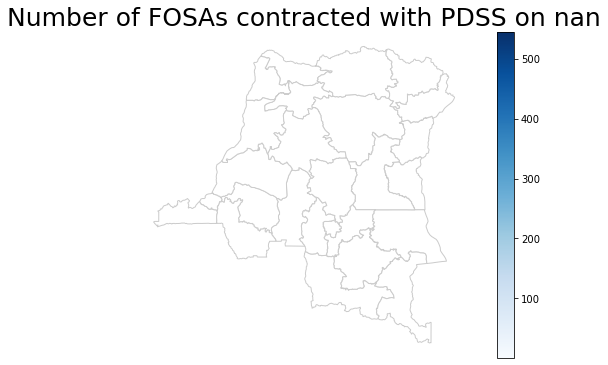

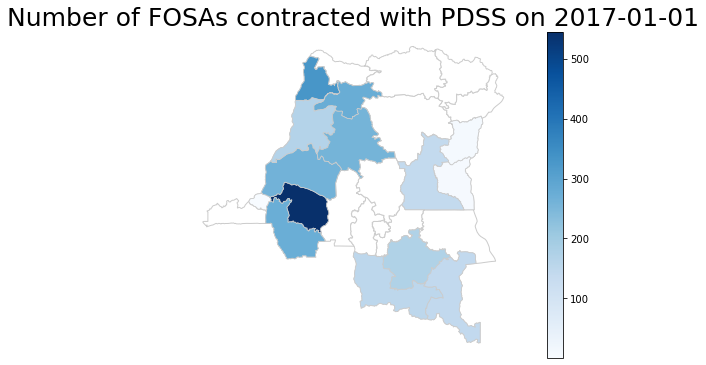

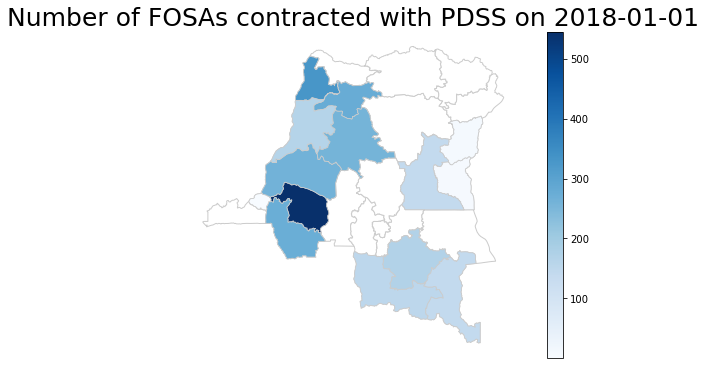

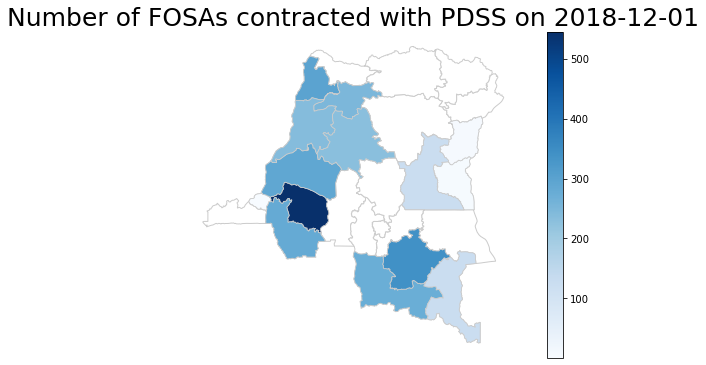

In [26]:
provinces_df = provinces_df.merge(snis.organisationunit, left_on="org_unit_I", right_on="uid")
provinces_df.name = provinces_df.name.str.lower()

pdss_provinces = pdss.organisationunit[pdss.organisationunit.name.str.contains("DPS")]
pdss_provinces.name = pdss_provinces.name.str.lower().str.replace(" dps", " province")

provinces_df = provinces_df.merge(province_start, left_on='name', right_on = "DPS", suffixes=["_snis", "_pdss"], how = "left")

vmin = provinces_df.n_fosa.min()
vmax = provinces_df.n_fosa.max()


for date in provinces_df.date.unique():
    fig, ax = plt.subplots(1, figsize=(10, 6))
    map_df[map_df.org_unit_I.isin(snis.orgunitstructure.uidlevel2).tolist()].plot(ax=ax, color="w", edgecolor=".8")
    provinces_df[provinces_df.date == date].plot(column="n_fosa", cmap="Blues", ax=ax, linewidth=0.8, edgecolor="0.8")
    ax.axis('off')
    ax.set_title("Number of FOSAs contracted with PDSS on " + str(date), fontdict={'fontsize': '25', 'fontweight' : '3'})
    sm = plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(vmin=vmin, vmax=vmax))
    sm._A = []
    cbar = fig.colorbar(sm)

## Counterfactual Analysis

In [27]:
pdss_provinces = share_province.uidlevel2[share_province.name.str.contains('|'.join(["eq ","hk ","hl ","ll ","mg ", "mn ","sk ", "nk ", "su ", "tu ", "kg ", "kl "]))].unique().tolist()
snis_pdss = snis_extract[(snis_extract.uidlevel2.isin(pdss_provinces))]

In [33]:
def make_counterfactual(snis_indicator, snis_pdss=snis_pdss, pdss_extract=pdss_extract,  pdss_indcator= None):
    snis_data = snis_pdss[snis_pdss.dataelementname == snis_indicator]
    snis_pdss_average = snis_data[snis_data.uidorgunit.isin(snis_pdss_map["SNIS Facility ID"].tolist())].groupby("enddate").value.apply(np.mean).reset_index()
    snis_non_pdss_average = snis_data[~ snis_data.uidorgunit.isin(snis_pdss_map["SNIS Facility ID"].tolist())].groupby("enddate").value.apply(np.mean).reset_index()
    ref = snis_non_pdss_average[snis_non_pdss_average.enddate == min(snis_non_pdss_average.enddate)].value.iloc[0]
    counterfactual = snis_pdss_average.value[snis_pdss_average.enddate == min(snis_pdss_average.enddate)].iloc[0] * snis_non_pdss_average.value / ref
    return {"snis_pdss_average":snis_pdss_average, "snis_non_pdss_average":snis_non_pdss_average, "counterfactual":counterfactual}

def make_counterfactual_plot(counterfactual_dic, title):
    plt.figure(figsize = (20, 10))
    counterfactual_dic["snis_pdss_average"].enddate
    plt.plot(counterfactual_dic["snis_pdss_average"].enddate, counterfactual_dic["snis_pdss_average"].value, 
                 label = "pdss")
    plt.plot(counterfactual_dic["snis_non_pdss_average"].enddate, counterfactual_dic["snis_non_pdss_average"].value, 
                 label = "non - pdss")
    plt.plot(counterfactual_dic["snis_non_pdss_average"].enddate, counterfactual_dic["counterfactual"], 
                 label = "pdss counterfactual")
    plt.ylim(0)
    plt.legend(bbox_to_anchor = (1,1))
    plt.title(title)

In [ ]:
for indic in snis_pdss[~snis_pdss.dataelementname.str.contains('a 4.')].dataelementname.unique():
    print(indic)
    count = make_counterfactual(indic)
    make_counterfactual_plot(count,indic)

## PDSS as share of Total services

In [92]:
variables_dict = {"consultation prénatale 4ème visite - ver":"ANC4", "a 2.1 cpn 4":"ANC4",
                  "consultation prénatale 1ère visite - ver":"ANC1", "a 2.1 cpn 1":"ANC1",
                  "paludisme simple confirmé":"confirmed_malaria", 
                  "Paludisme simple confirmé traité \(PN\)":"treated_malaria",
                  "consultation postnatale - ver":"PNC", 
                  "enfant complètement vacciné - ver":"fully_immunized_children",
                  "accouchement assisté - ver":"assisted_delivery", 
                  "a 2.3 accouchements par personnel qualifié":"assisted_delivery"}

snis_compare = snis_extract[(snis_extract.uidlevel2.isin(pdss_provinces))]

In [93]:
snis_compare = snis_compare.merge(snis.organisationunit[["uid","name"]], left_on="uidlevel2", right_on="uid")

In [150]:
def make_share(snis_data):
    #snis_data = snis_data.groupby("uid").apply(select_fosa, .8, "201701","201901").reset_index()
    snis_pdss_total = snis_data[snis_data.uidorgunit.isin(snis_pdss_map["SNIS Facility ID"].tolist())].groupby("enddate").value.apply(sum).reset_index()
    snis_non_pdss_total = snis_data.groupby("enddate").value.apply(sum).reset_index()
    full_dat = snis_non_pdss_total.merge(snis_pdss_total, on = "enddate")
    prop_out = full_dat.value_y / full_dat.value_x
    pdss_out = snis_pdss_total.value
    non_pdss_out = snis_non_pdss_total.value
    if len(pdss_out) == 0:
        pdss_out = non_pdss_out - non_pdss_out
    dict_out = {"snis_pdss_total":pdss_out, 
                        "snis_non_pdss_total":non_pdss_out, 
                        "proportion":prop_out,
                        "dates":snis_non_pdss_total.enddate}
    return pd.DataFrame(dict_out)

def make_share_plot(share, dataelement):
    share = share.dropna()
    plt.figure(figsize = (20, 10))
    datp = share[share.dataelementname == dataelement]
    for uid in datp.name.unique():
        datpp = datp[datp.name == uid]
        plt.plot(datpp.dates, datpp.proportion, label = uid)
    nat = datp.groupby("dates").apply(lambda x: x.snis_pdss_total.sum()/ x.snis_non_pdss_total.sum()).reset_index()
    plt.plot(nat.dates, nat[0], "r" ,linewidth=8, label = "all provinces")
    plt.legend(bbox_to_anchor = (1,1))
    plt.title(dataelement)
    plt.ylim(0,1)

In [108]:
%%time
snis_compare_filled = snis_compare
snis_compare_filled.value = snis_compare_filled.value.fillna(0)
snis_compare_filled = snis_compare_filled[~(snis_compare_filled.name.str.contains("eq")) & ~(snis_compare_filled.dataelementname.str.contains("a 4"))]

CPU times: user 10.9 s, sys: 44.6 s, total: 55.5 s
Wall time: 1min 18s


In [151]:
%%time
print("computing share")
plot_d = snis_compare_filled.groupby(["name", "dataelementname"]).apply(make_share)

computing share
CPU times: user 46.6 s, sys: 1min 36s, total: 2min 23s
Wall time: 3min 19s


In [152]:
%%time
plot_d = plot_d.reset_index()

CPU times: user 3.82 ms, sys: 4.75 ms, total: 8.56 ms
Wall time: 8.1 ms


/anaconda3/envs/geo_env/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


CPU times: user 1.76 s, sys: 915 ms, total: 2.67 s
Wall time: 3.49 s


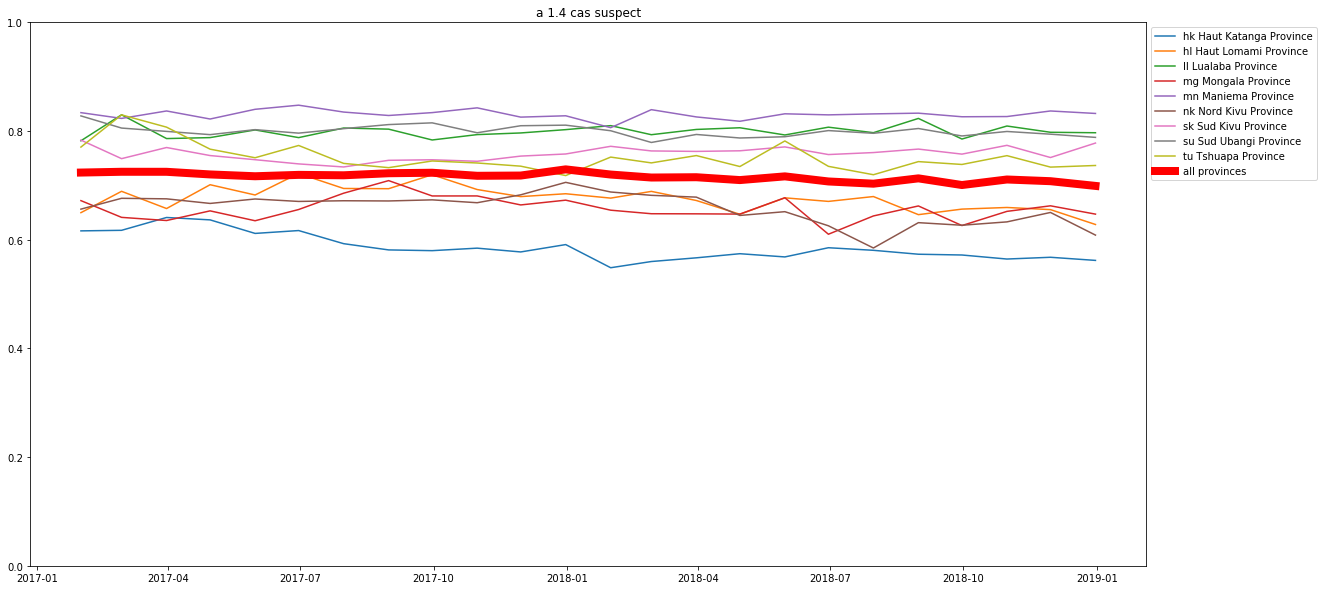

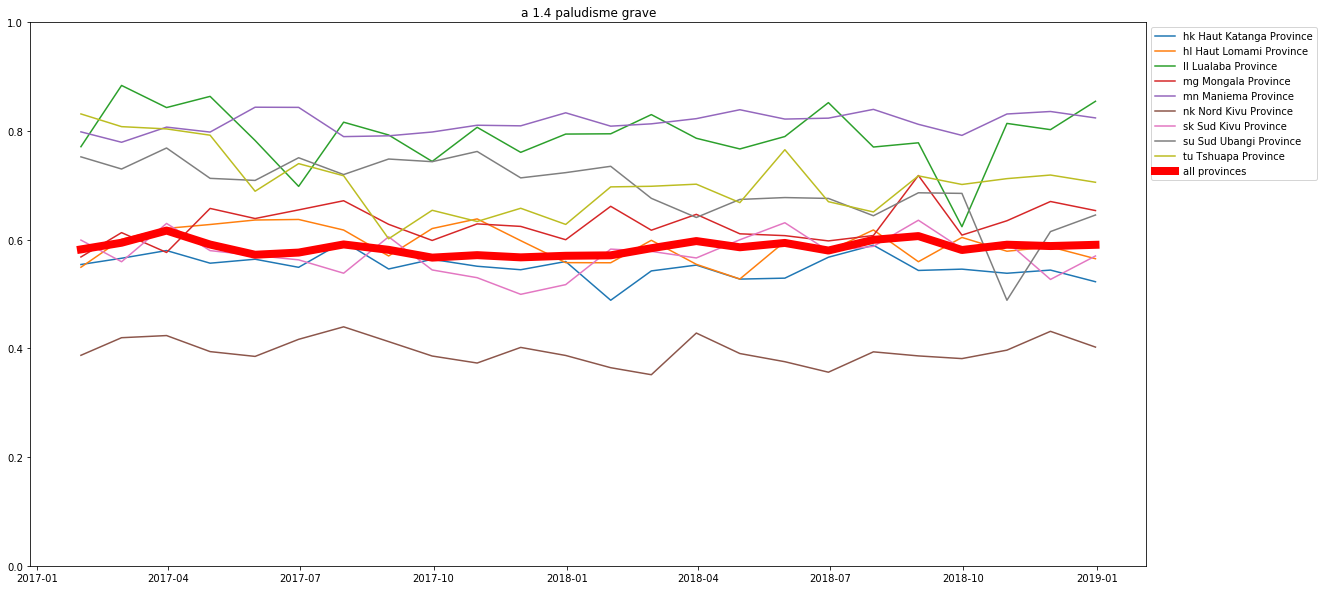

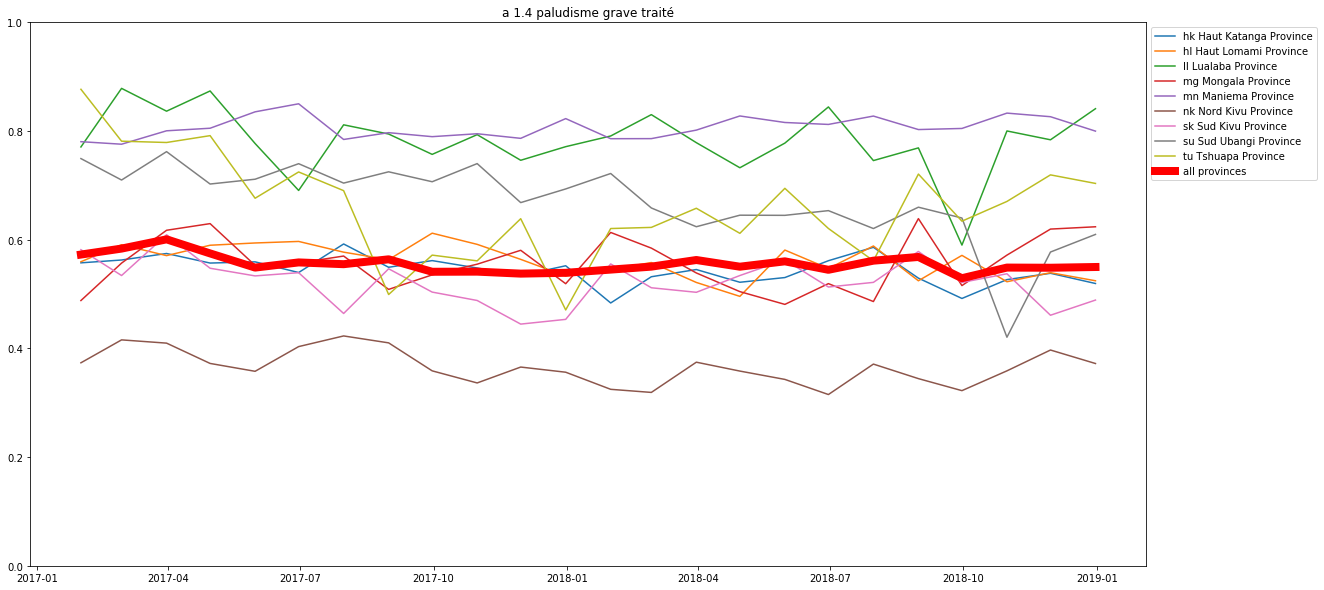

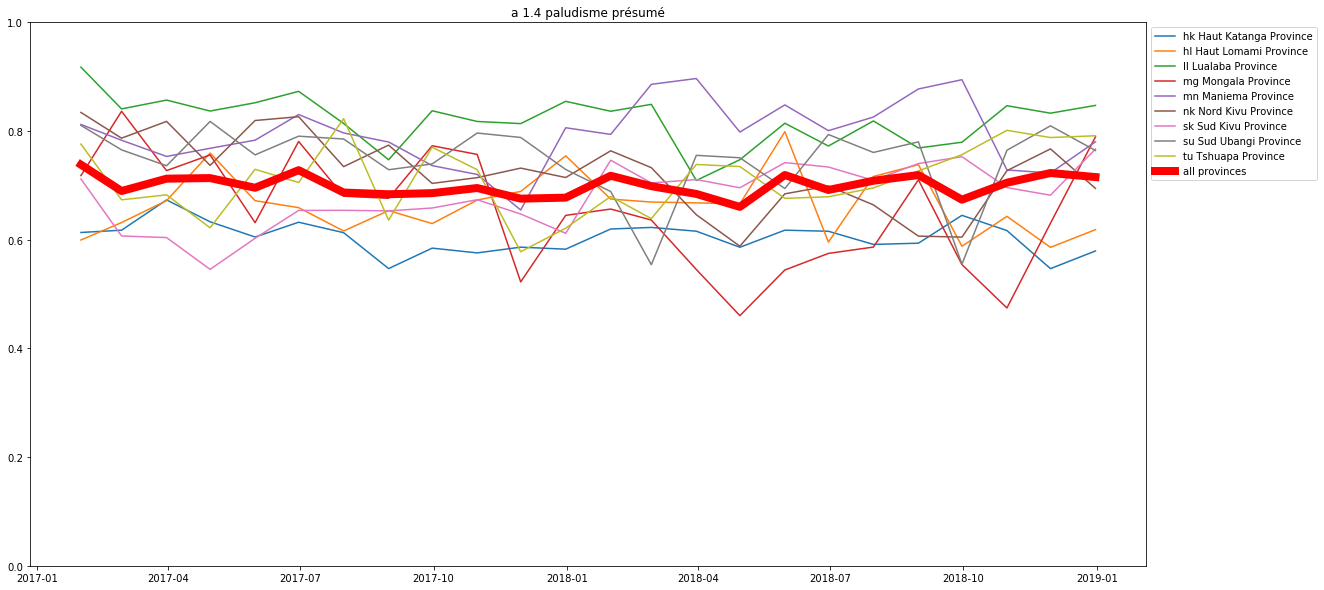

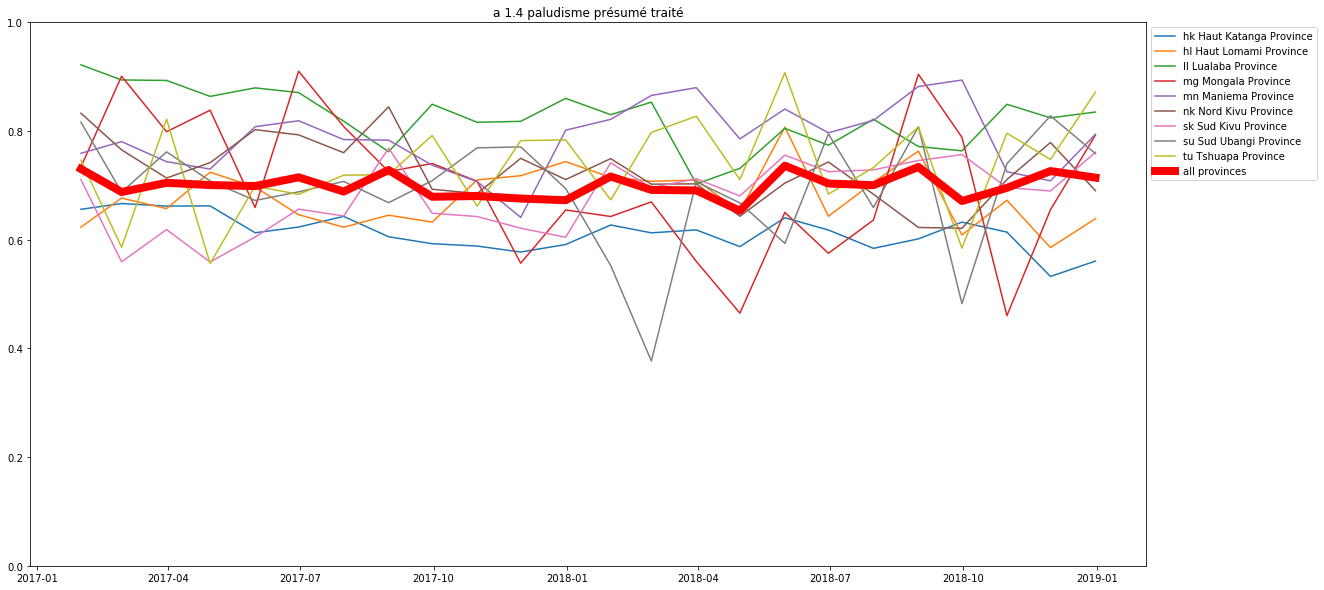

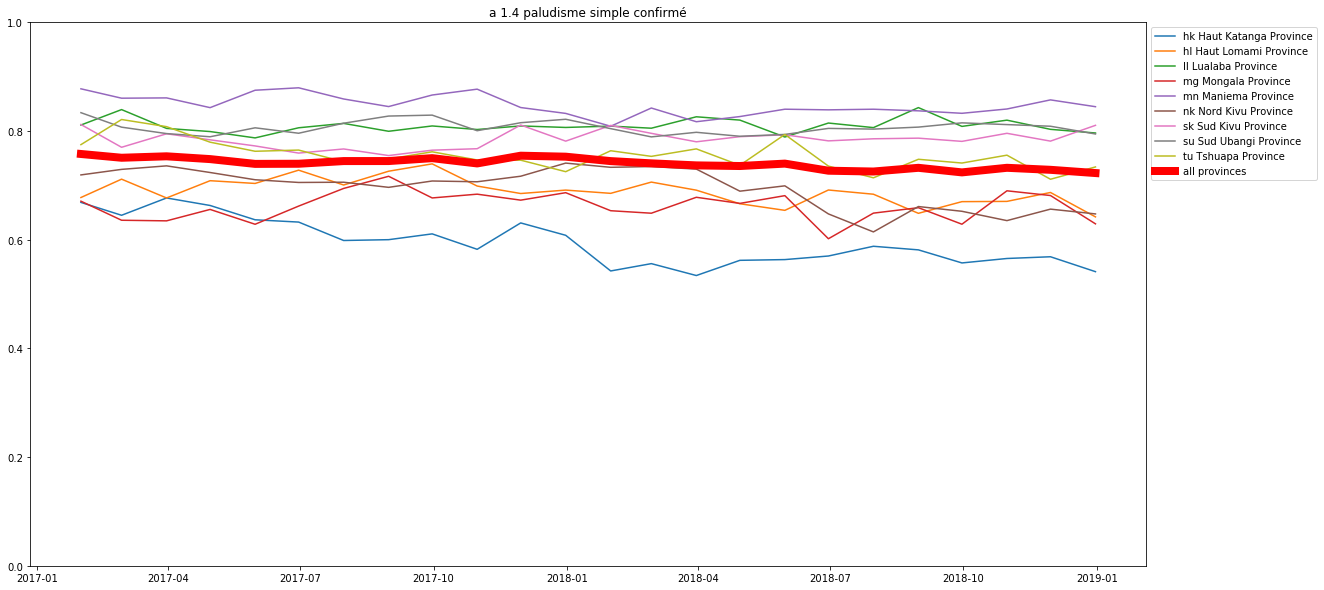

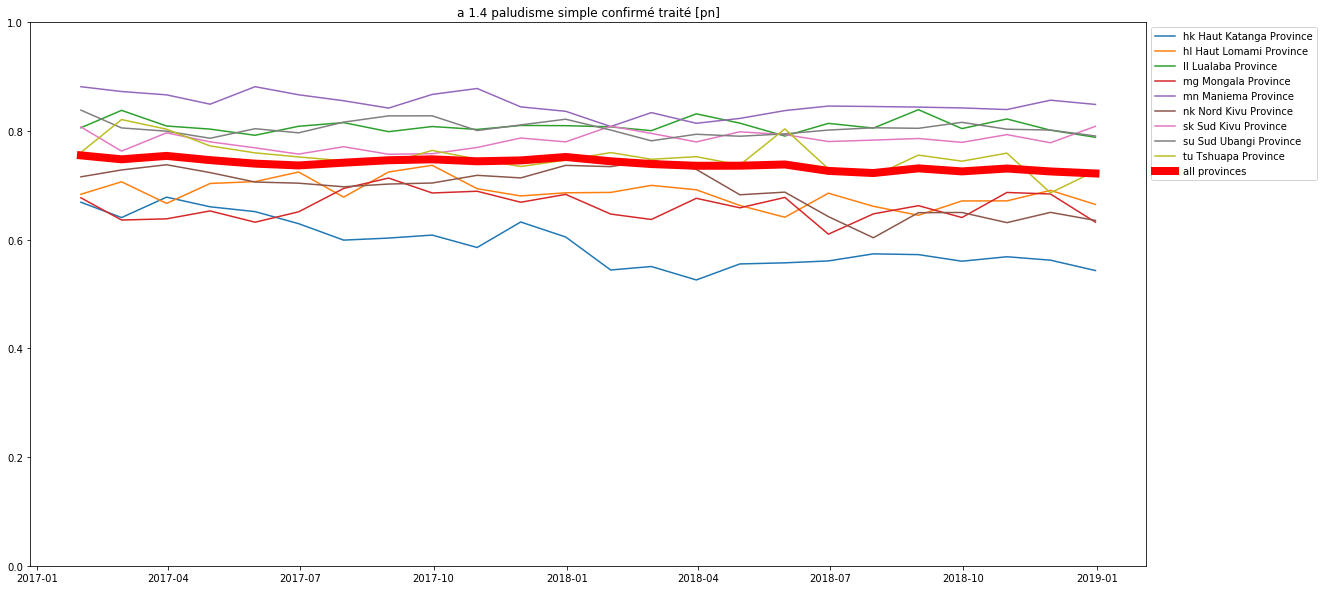

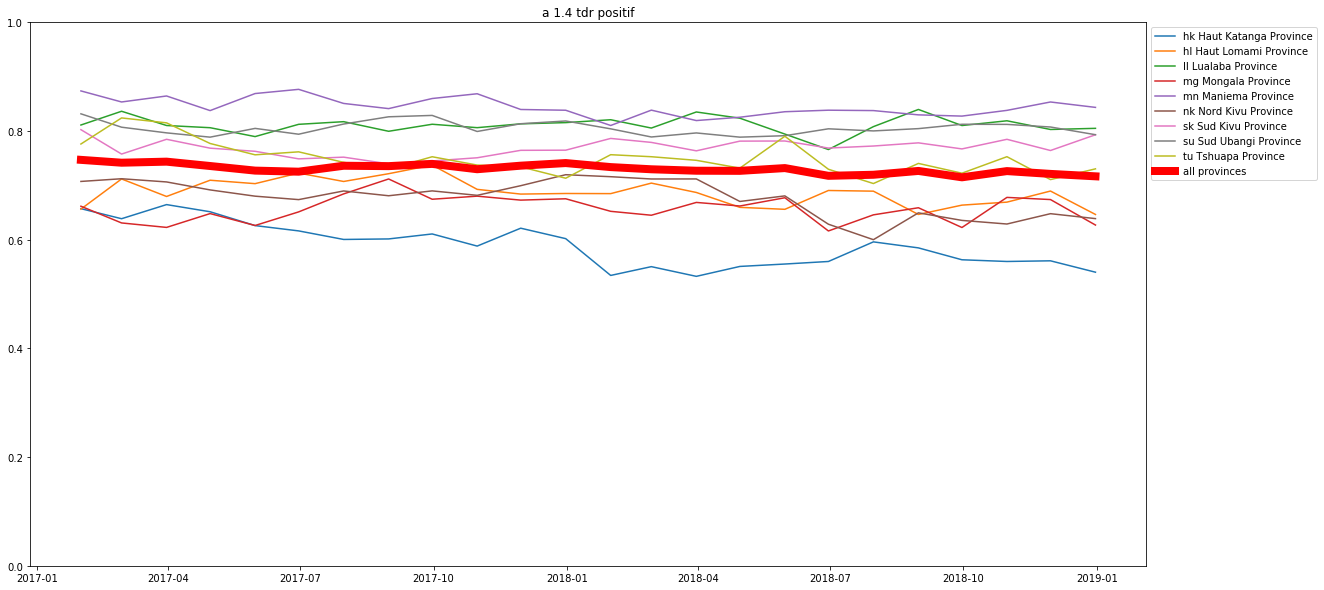

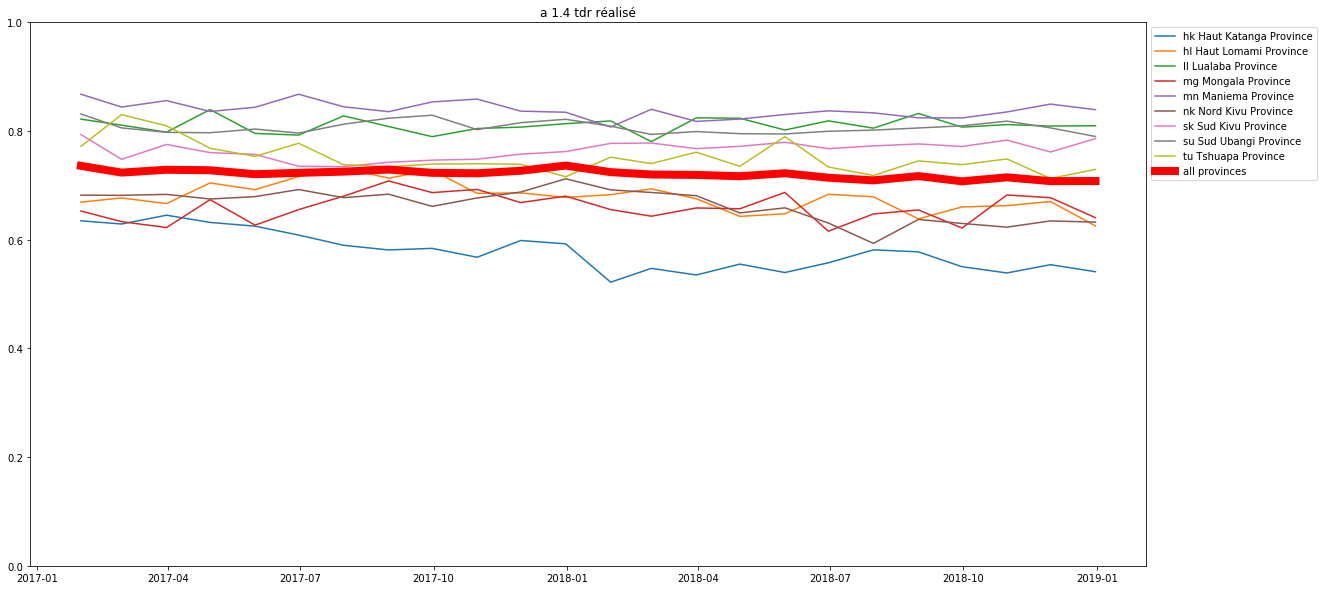

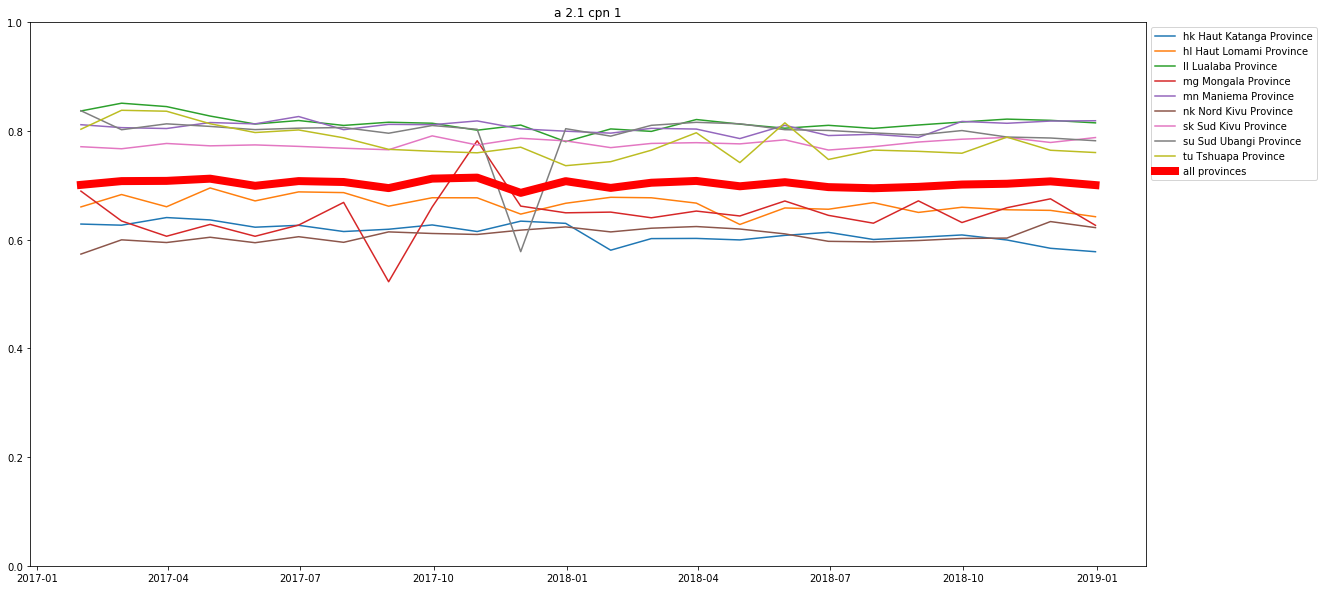

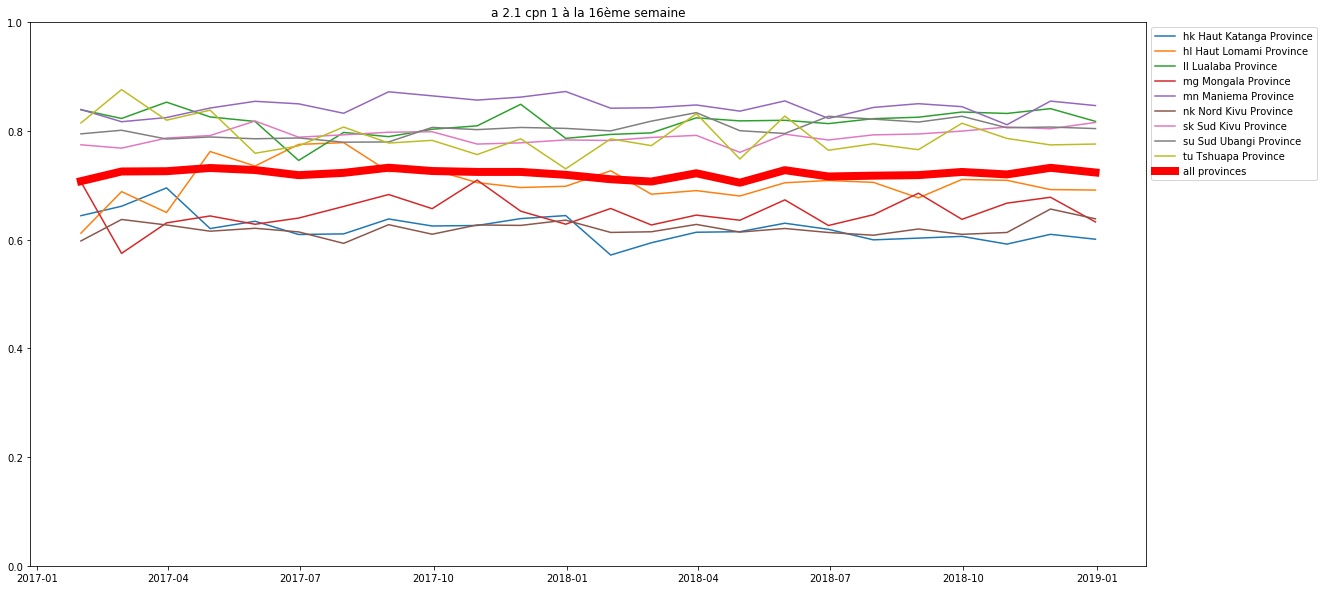

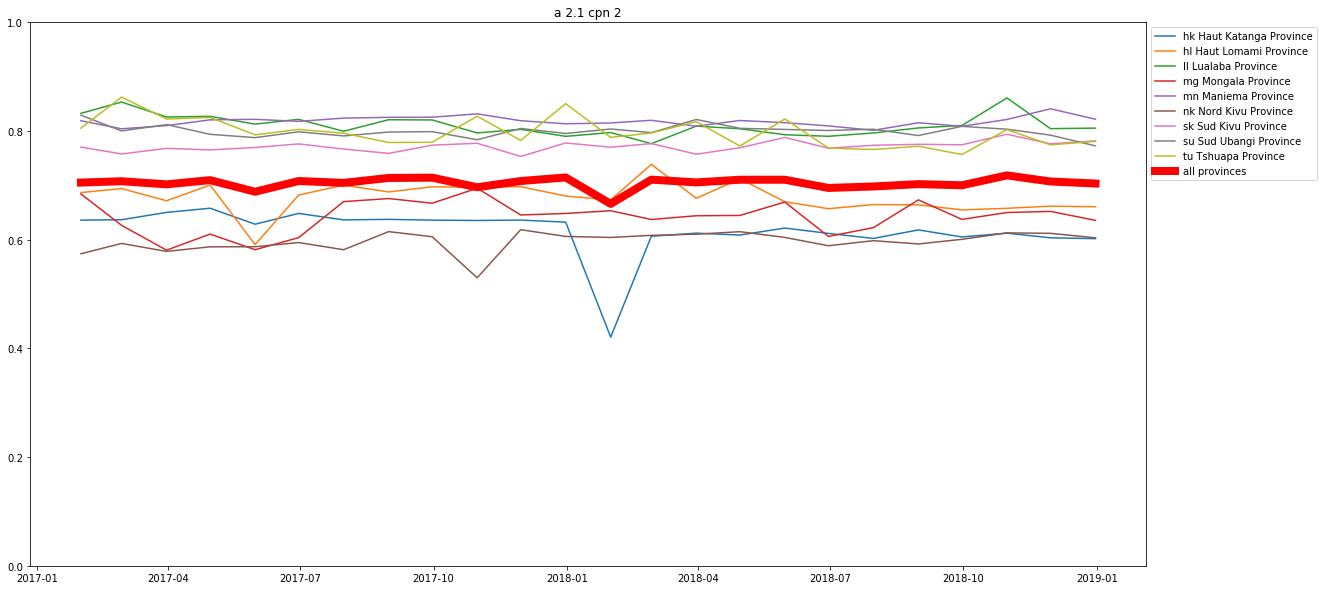

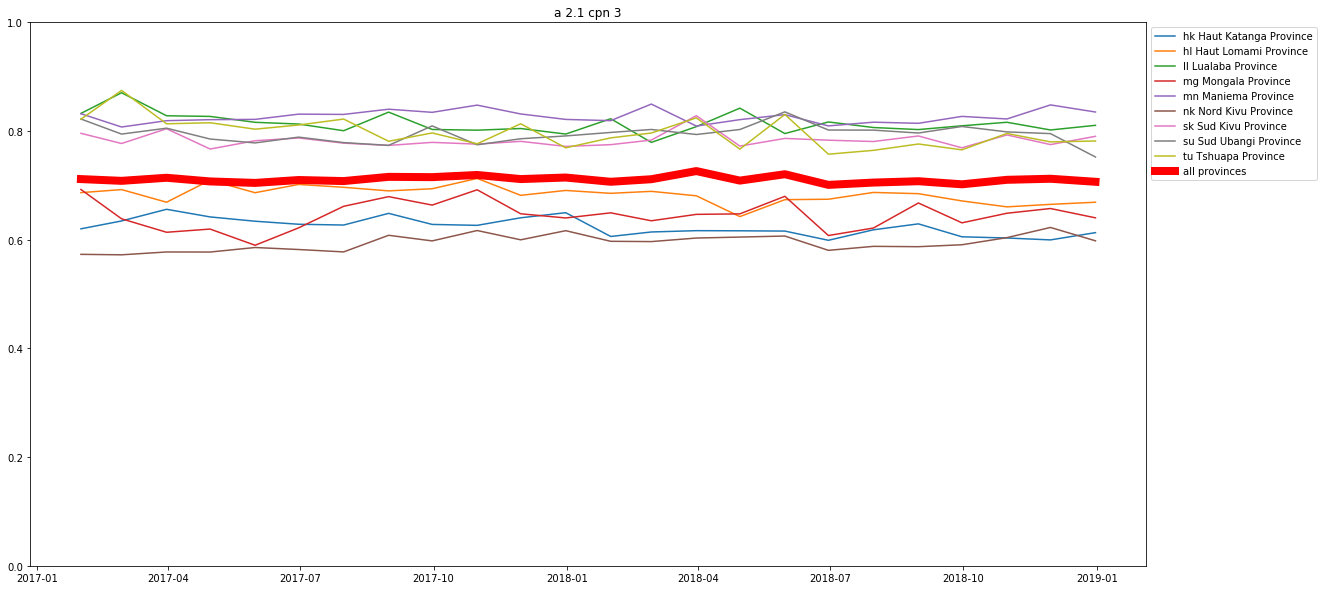

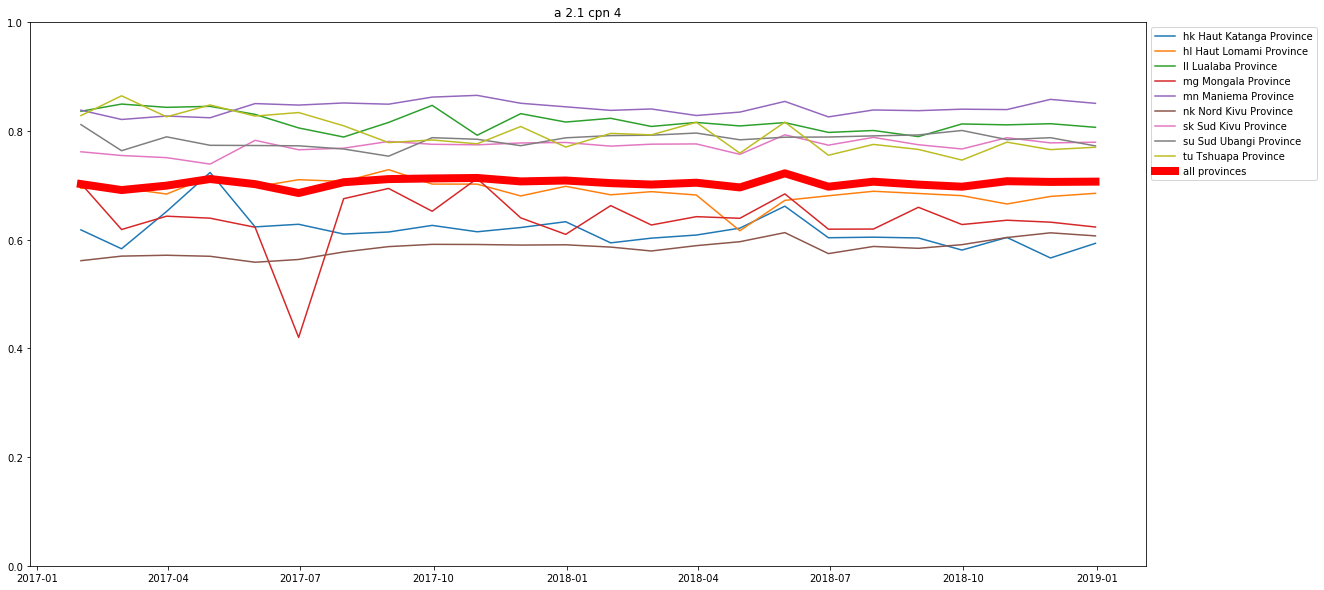

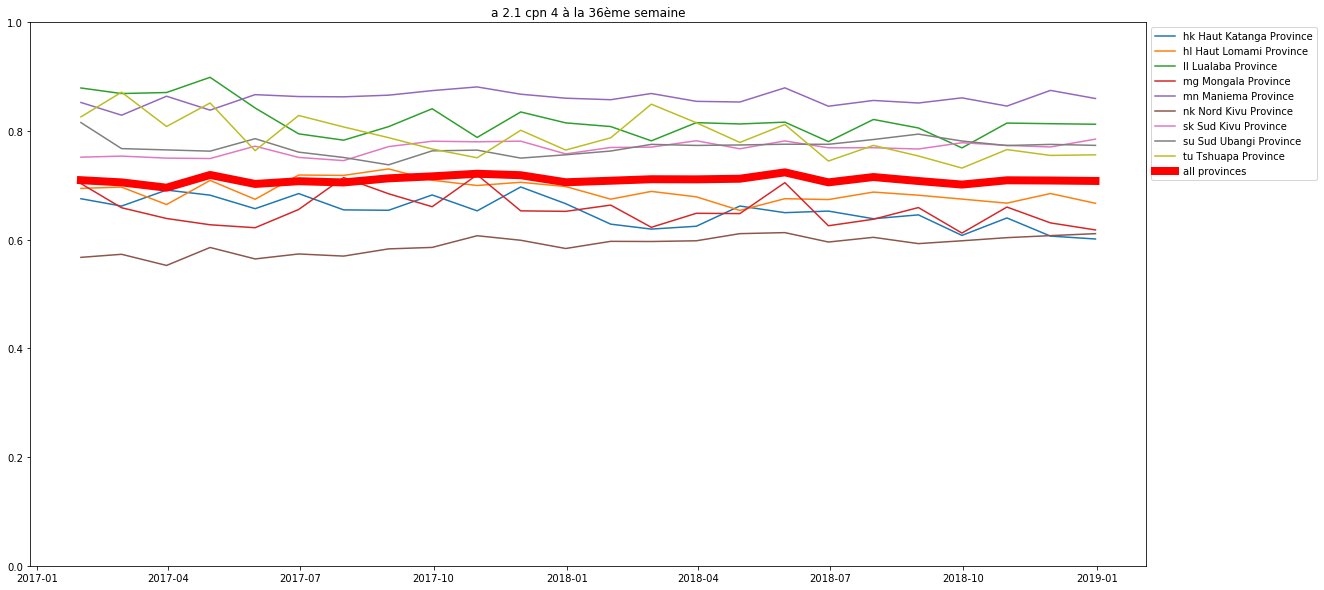

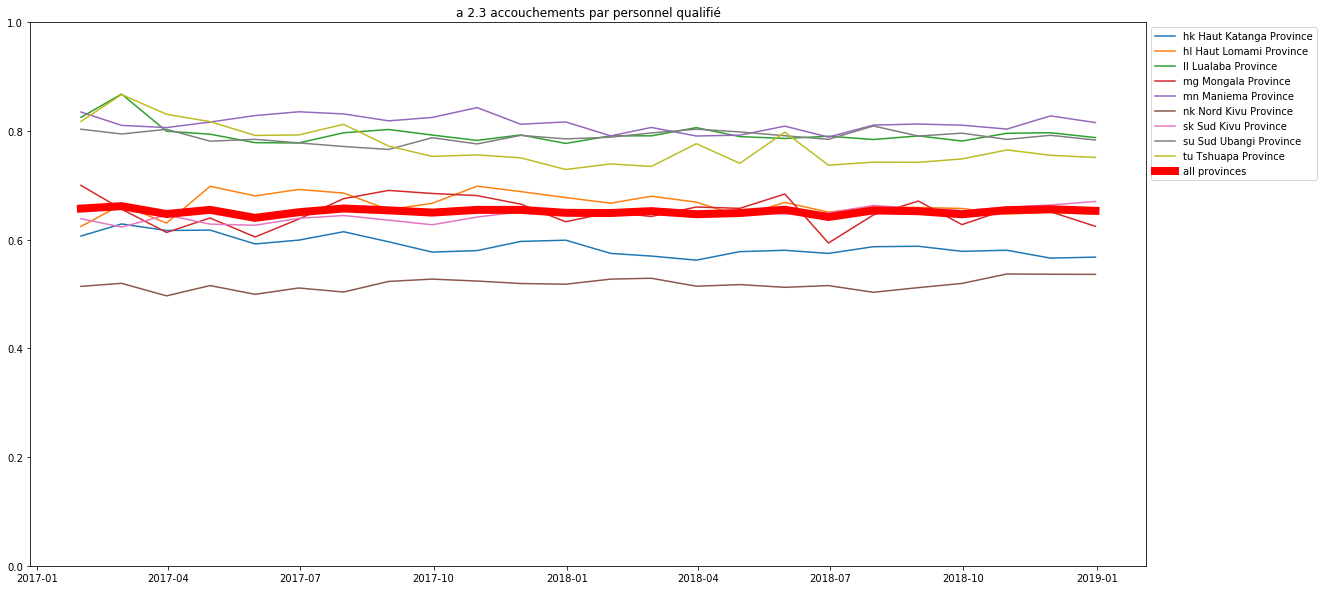

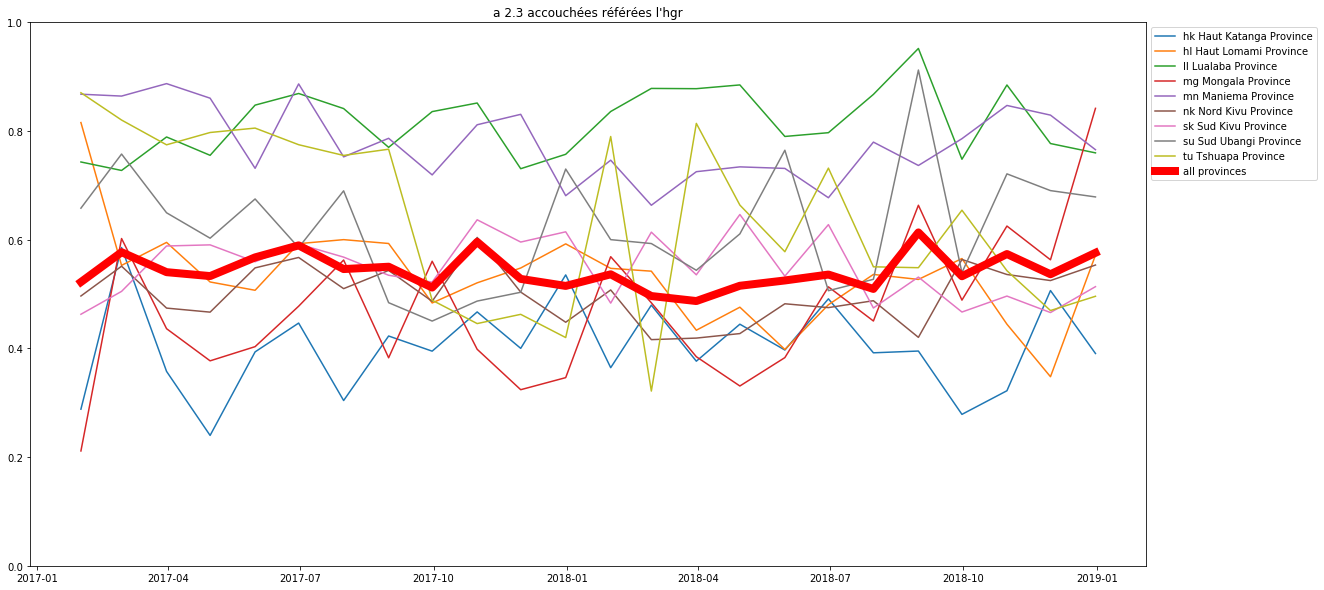

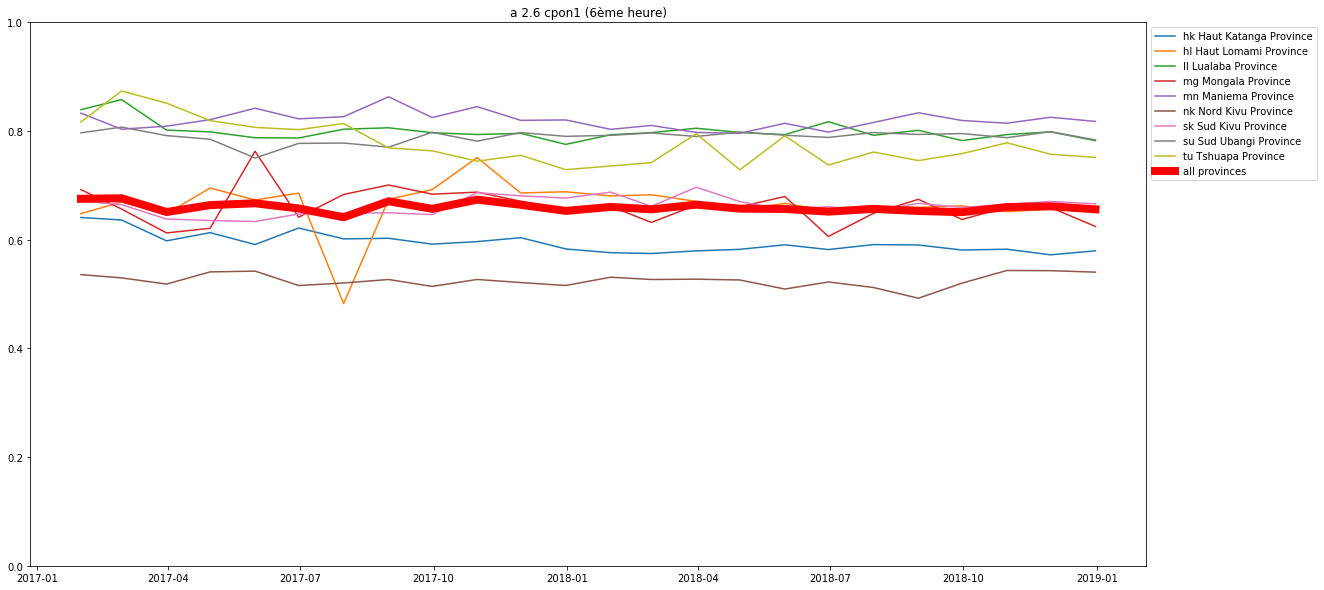

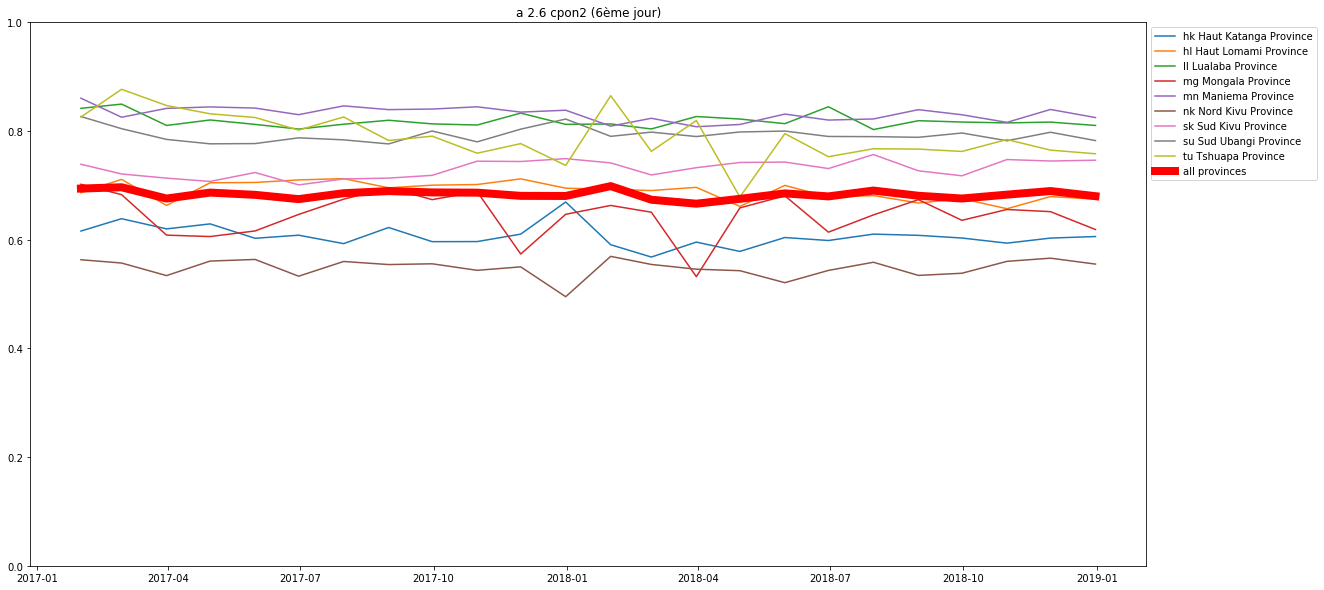

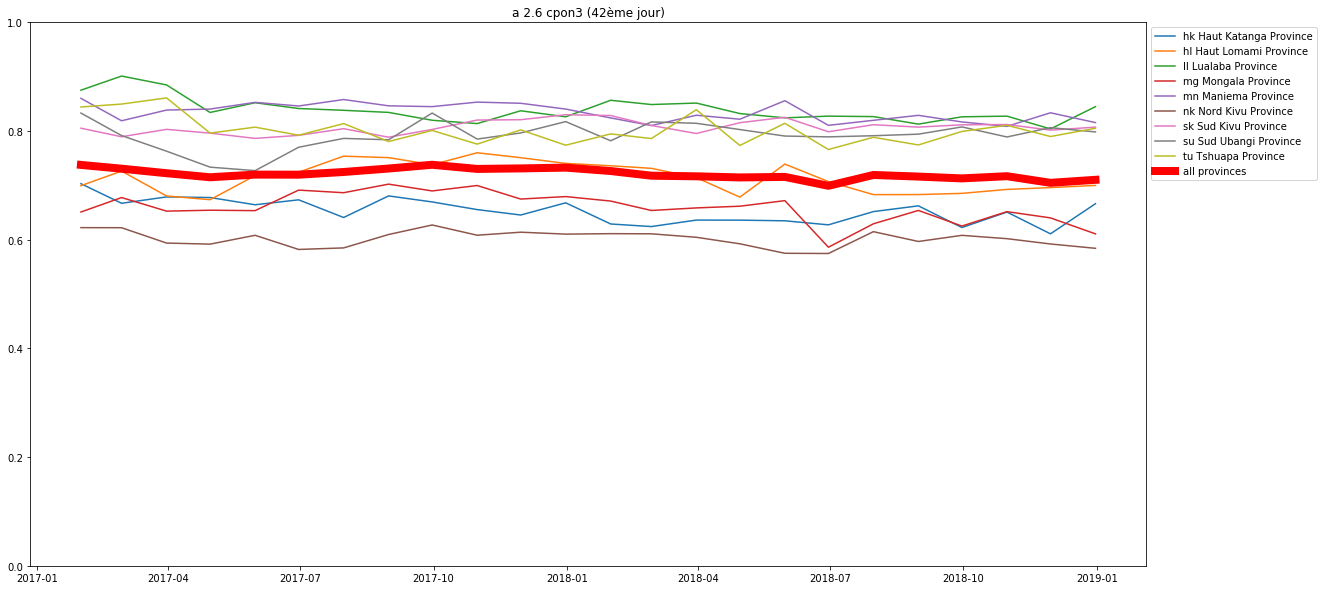

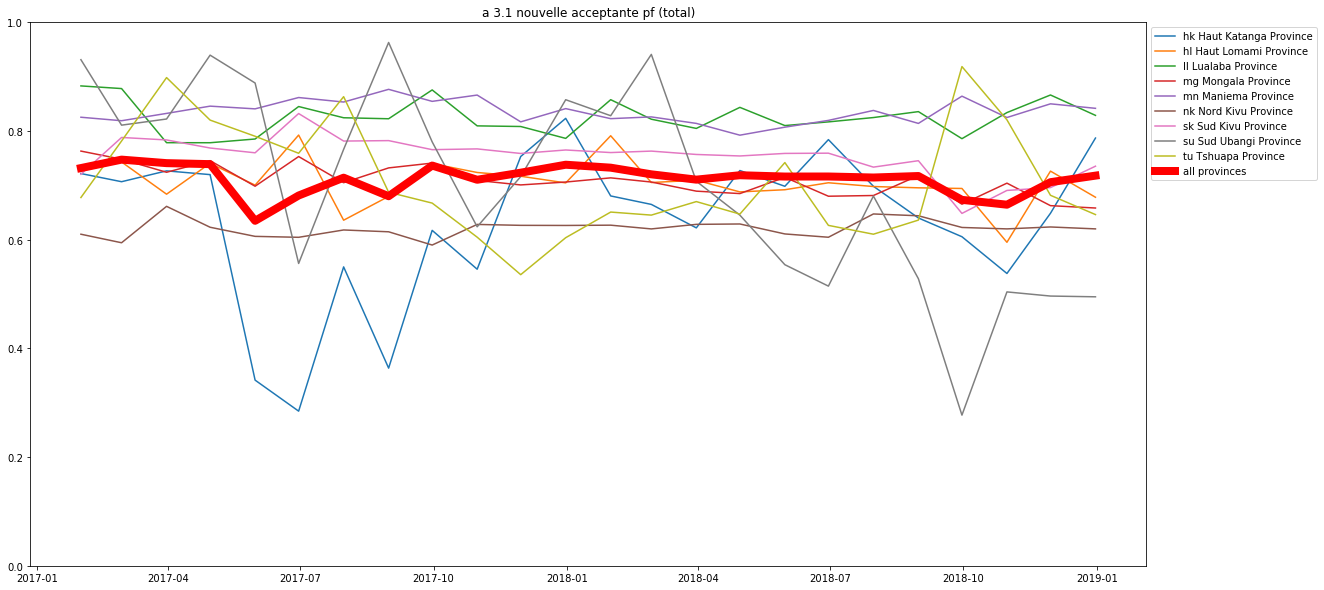

In [153]:
%%time
for dataelement in plot_d.dataelementname.unique():
    make_share_plot(plot_d, dataelement)

### Comparing SNIS and PDSS

In [154]:
# taking appart data for SNIS to PDSS comparison
snis_compare = snis_extract[snis_extract.dataelementname.isin(variables_dict.keys())]
pdss_compare = pdss_extract[pdss_extract.dataelementname.isin(variables_dict.keys())]

In [160]:
def make_comparison_frame(data, dhis):
    full = data.groupby(["dataelementname","uidlevel2","enddate"]).value.apply(sum)
    full = full.reset_index().merge(dhis.organisationunit[["uid","name"]], left_on="uidlevel2", right_on="uid").set_index(["dataelementname", "name", "enddate"]).rename(variables_dict).drop(["uid","uidlevel2"], axis=1).reset_index()
    full.name = full.name.str.replace(" DPS| Province","").str.strip()
    return full

In [163]:
full_snis = make_comparison_frame(snis_compare, snis)
full_pdss = make_comparison_frame(pdss_compare, snis)

In [183]:
full_merged = full_snis.merge(full_pdss, on = ["enddate","name","dataelementname"], suffixes = ["_snis","_pdss"])

In [184]:
full_merged = full_merged[~full_merged.enddate.isin(["2017-04-30"])]

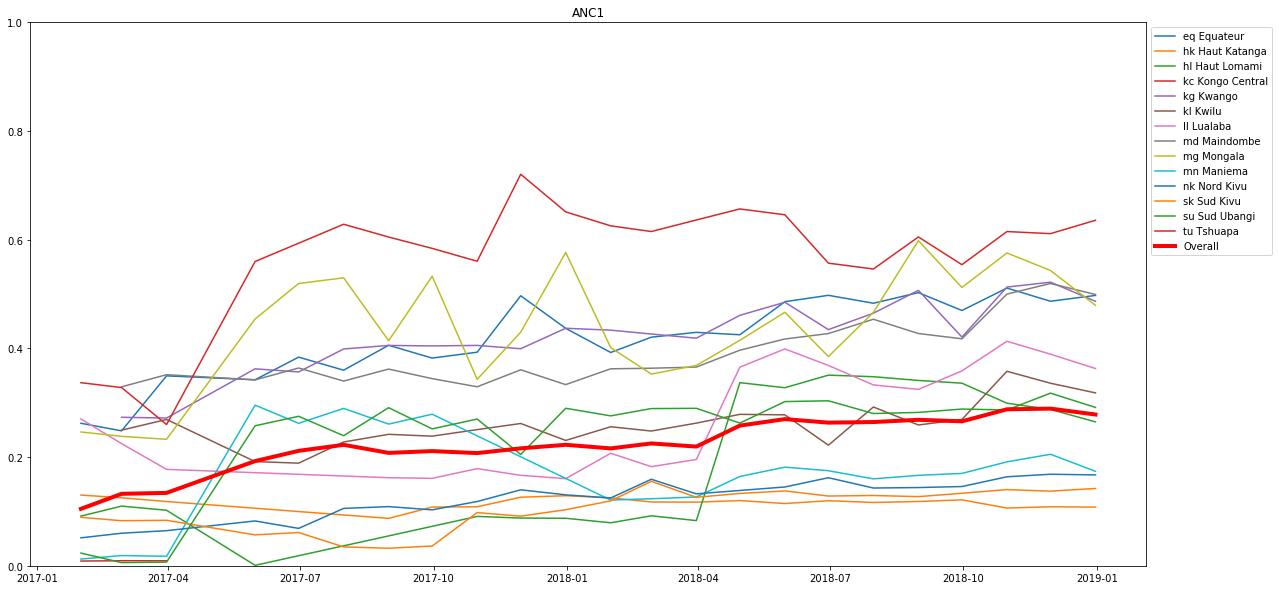

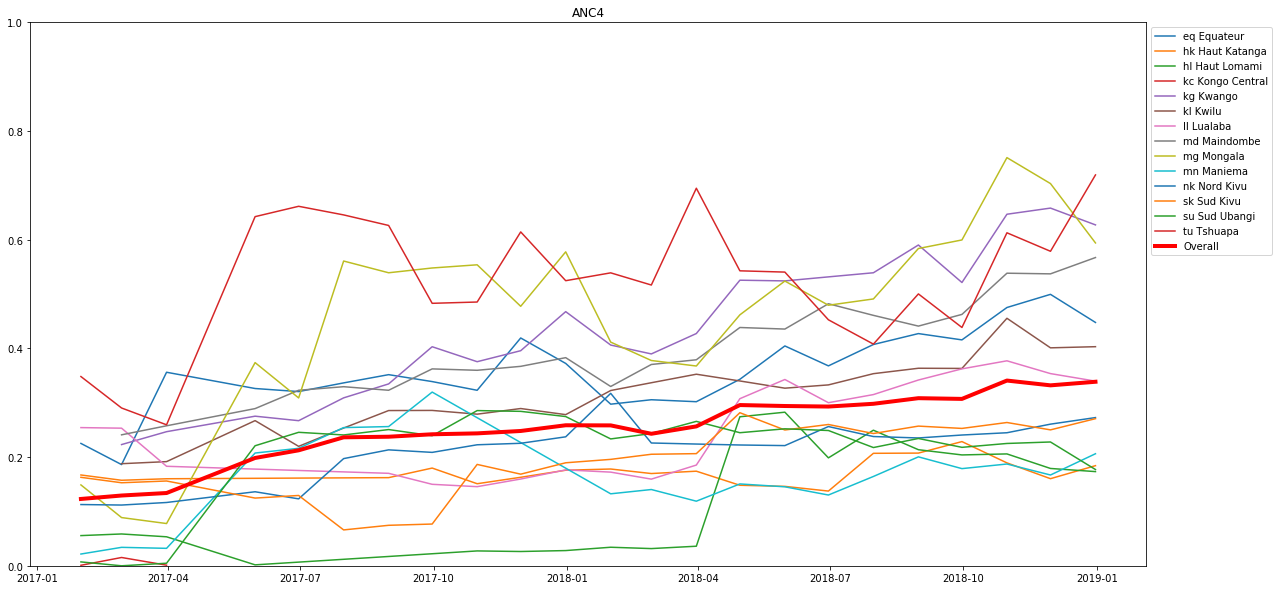

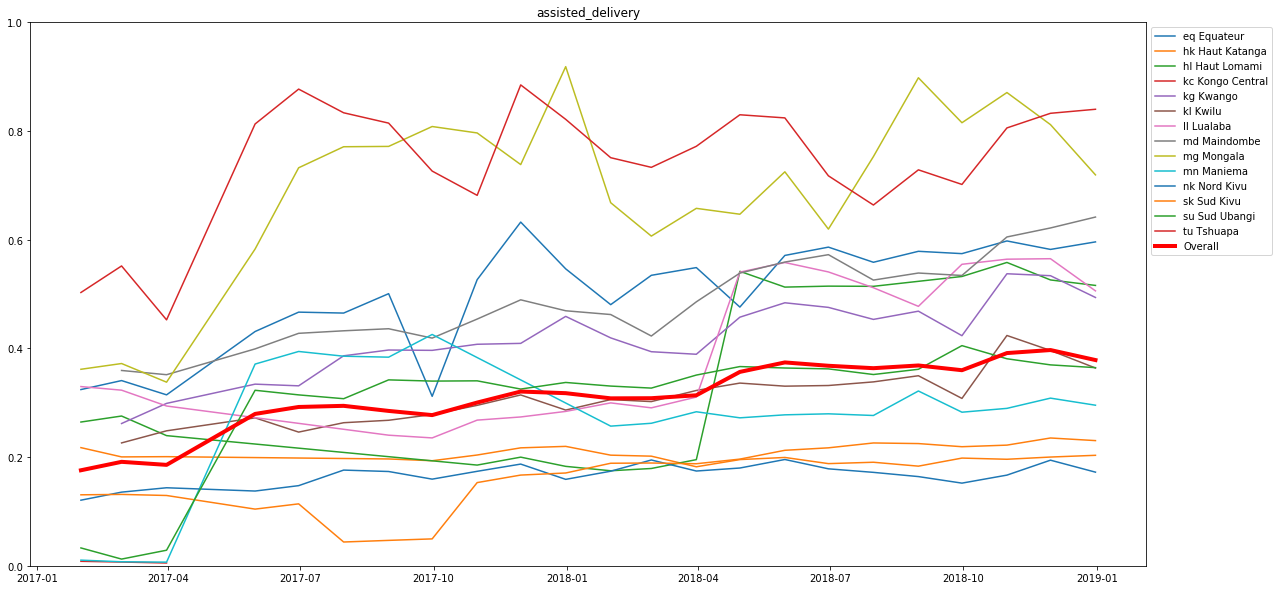

In [186]:
for serie in full_merged.dataelementname.unique():
    fig1 = plt.figure(figsize = (20, 10))
    dat_p = full_merged[(full_merged.dataelementname == serie)]
    dat_p2 = dat_p.groupby(["name", "enddate"]).apply(lambda x: x.value_pdss.sum()/x.value_snis.sum()).reset_index()
    dat_p2 = dat_p2.rename({0:"value"}, axis = 1)
    for province in dat_p2.name.unique():
        plt.plot(dat_p2.loc[dat_p2.name == province,"enddate"],dat_p2.loc[dat_p2.name == province,"value"], label = province)
    dat_pn = dat_p.groupby(["enddate"]).apply(lambda x: x.value_pdss.sum()/x.value_snis.sum()).reset_index()
    dat_pn = dat_pn.rename({0:"value"}, axis = 1)
    plt.plot(dat_pn.enddate,dat_pn.value, label = "Overall", linewidth = 4, color="red")
    plt.legend(bbox_to_anchor=(1,1))
    plt.title(serie)
    plt.ylim(0,1)

With the Programme de Développement du Système de Santé (PDSS), Results Based Funding (RBF) is playing an important role in the evolution of service provision in the DRC. In 2018, we estimate that around 15% of deliveries in the country were provided through PDSS funded facilities, as well as around 10% of ANC visits. When looking to provinces in which the PDSS is implemented, this proportion gets even higher. We estimated that PDSS funds well over 50% of assisted deliveries in the Equateur and Tshuapa provinces and over a third of first ANC visits in those provinces and the Mongala Province. 

Figure 1 also shows how this share of RBF funded service provision has rapidly grown in 2017, and has then followed a somewhat slower growth in 2018. 

## Growth Services

## In SNIS

In [202]:
snis_compare = snis_extract[snis_extract.dataelementname.isin(variables_dict)].groupby("uidorgunit").apply(select_fosa, .8, "201701","201901")

(0, 160489.45)

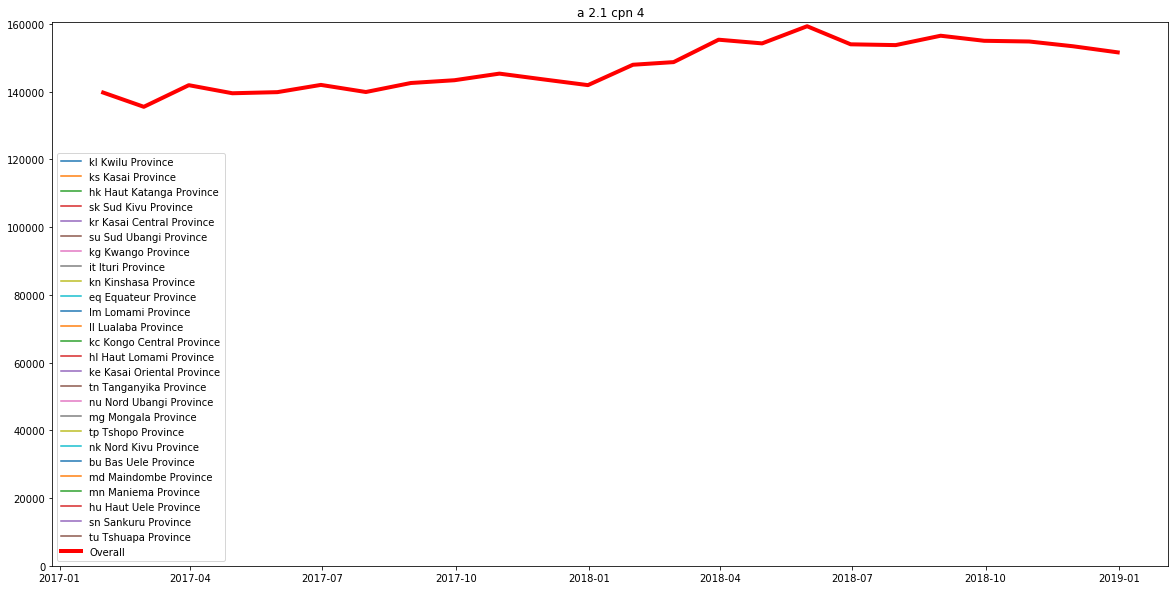

In [205]:
for serie in snis_compare.dataelementname.unique():
    fig1 = plt.figure(figsize=(20,10))
    dat_p = snis_compare[(snis_compare.dataelementname == serie)]
    dat_p2 = dat_p.groupby(["uidlevel2", "enddate"]).apply(lambda x: x.value.sum()).reset_index()
    dat_p2 = dat_p2.rename({0:"value"}, axis = 1)
    for province_id in dat_p2.uidlevel2.unique():
        province = snis.organisationunit.name[snis.organisationunit.uid == province_id].values[0]
        plt.plot(dat_p2.loc[dat_p2.uidlevel2 == province,"enddate"],dat_p2.loc[dat_p2.uidlevel2 == province,"value"], label = province)
    dat_pn = dat_p.groupby(["enddate"]).apply(lambda x: x.value.sum()).reset_index()
    dat_pn = dat_pn.rename({0:"value"}, axis = 1)
    plt.plot(dat_pn.enddate,dat_pn.value, label = "Overall", linewidth = 4, color="red")
    plt.legend()
    plt.title(serie)
    plt.ylim(0)

### In PDSS

In [214]:
dat_pn

enddate    value
0   2017-01-31   9065.0
1   2017-02-28   9104.0
2   2017-03-31  10290.0
3   2017-04-30   4548.0
4   2017-05-31  12381.0
5   2017-06-30  12487.0
6   2017-07-31  12824.0
7   2017-08-31  17864.0
8   2017-09-30  17653.0
9   2017-10-31  21868.0
10  2017-11-30  22884.0
11  2017-12-31  23944.0
12  2018-01-31  25494.0
13  2018-02-28  26327.0
14  2018-03-31  28496.0
15  2018-04-30  27710.0
16  2018-05-31  31168.0
17  2018-06-30  30944.0
18  2018-07-31  30634.0
19  2018-08-31  32053.0
20  2018-09-30  31857.0
21  2018-10-31  32086.0
22  2018-11-30  32902.0
23  2018-12-31  32605.0

In [257]:
pdss_compare = pdss_extract[pdss_extract.dataelementname.isin(variables_dict)].groupby(["uidorgunit","dataelementname"]).apply(select_fosa, .8, "201701","201901")

In [258]:
pdss_compare = pdss_compare.reset_index(drop=True)

In [259]:
pdss_compare = pdss_compare[~(pdss_compare.monthly == "201704")]

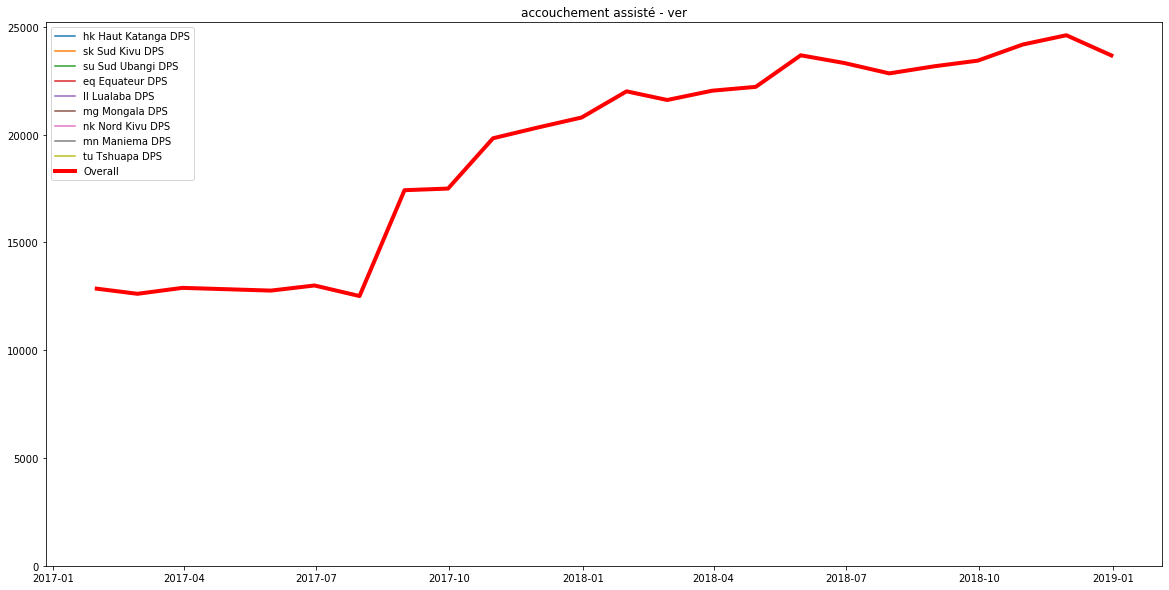

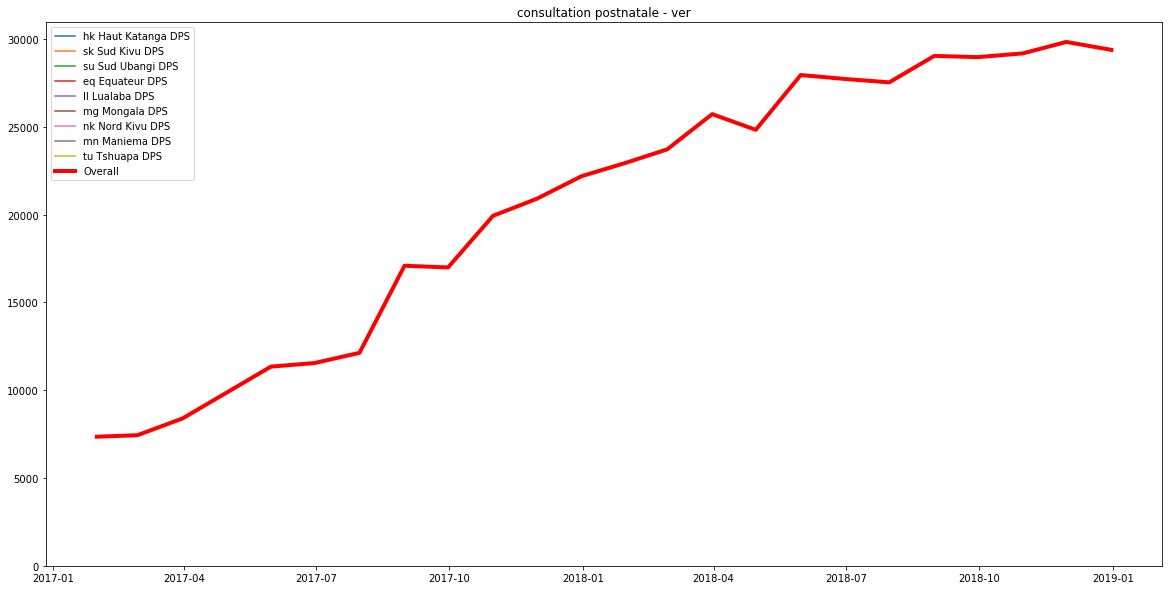

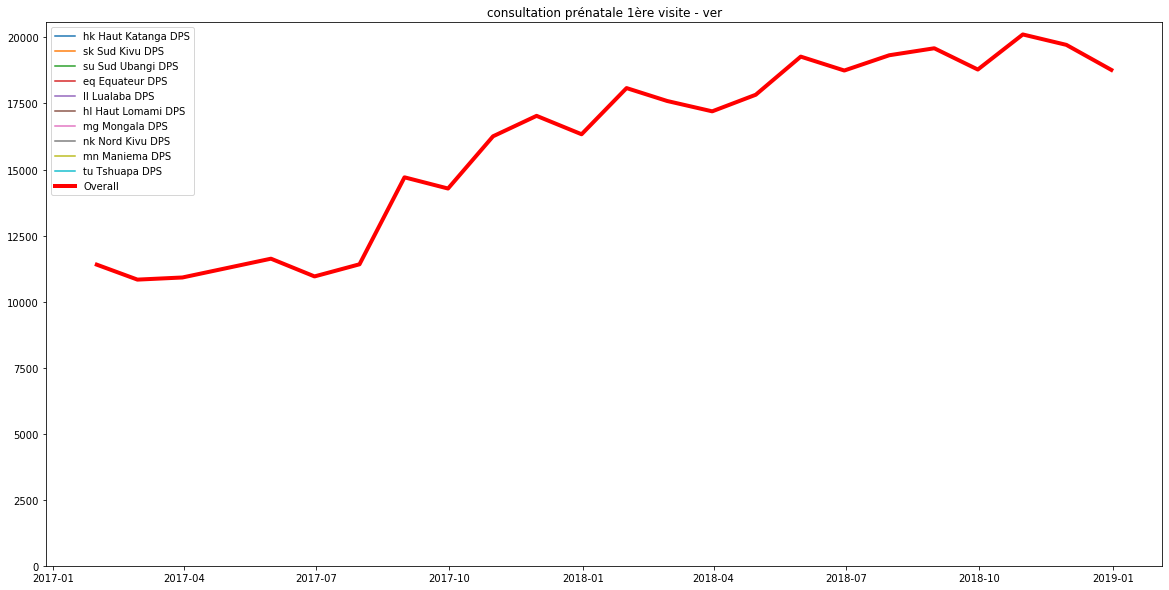

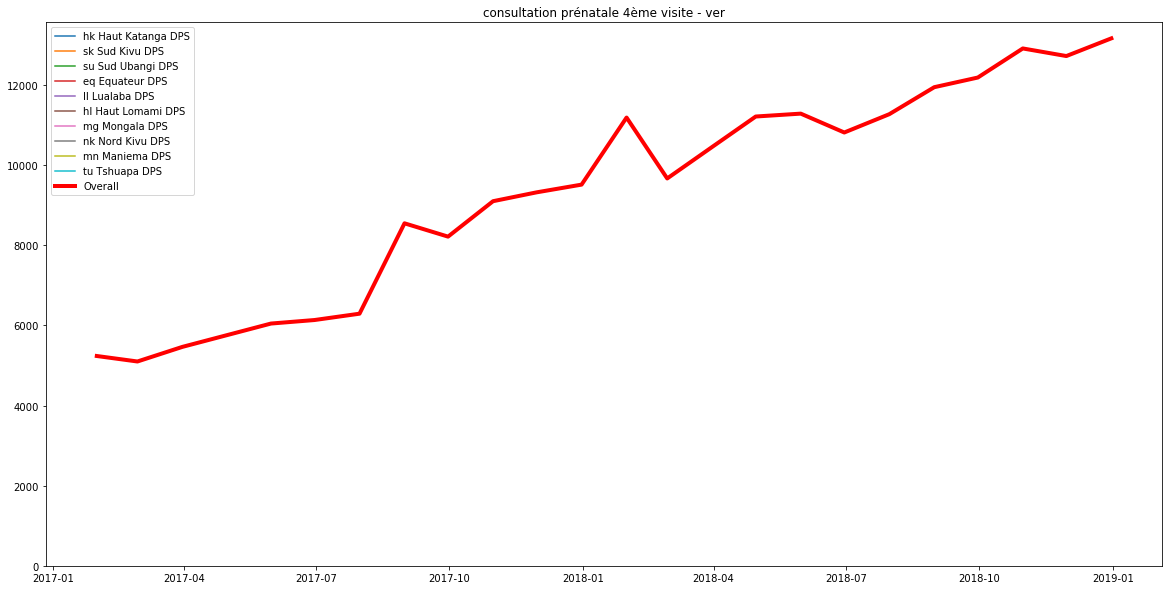

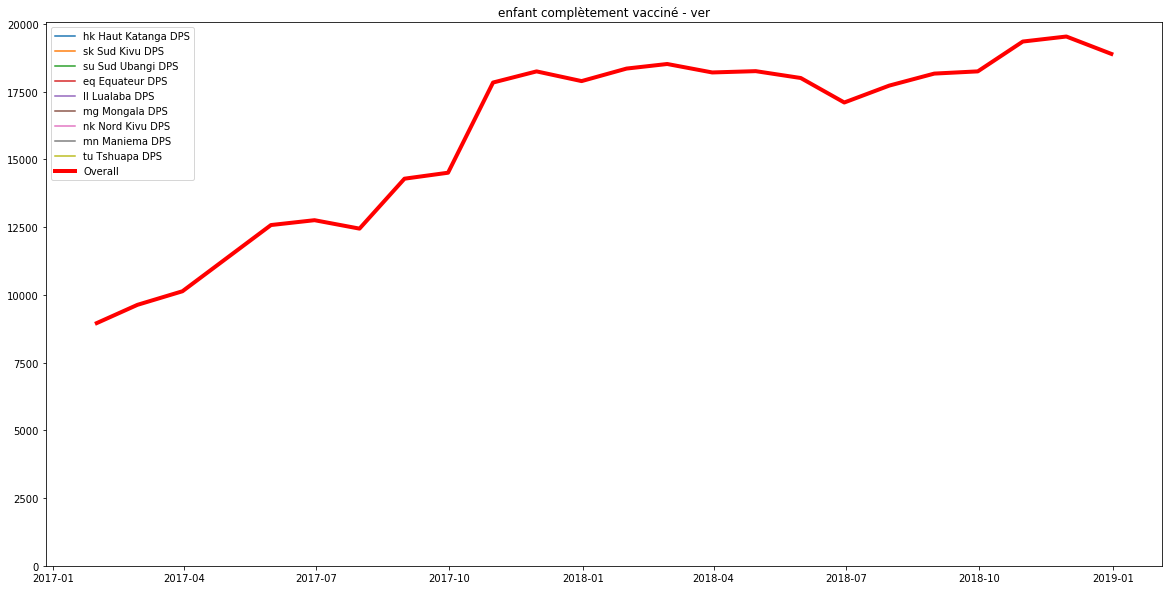

In [260]:
for serie in pdss_compare.dataelementname.unique():
    fig1 = plt.figure(figsize=(20,10))
    dat_p = pdss_compare[(pdss_compare.dataelementname == serie)]
    dat_p2 = dat_p.groupby(["uidlevel2", "enddate"]).apply(lambda x: x.value.sum()).reset_index()
    dat_p2 = dat_p2.rename({0:"value"}, axis = 1)
    for province_id in dat_p2.uidlevel2.unique():
        province = pdss.organisationunit.name[pdss.organisationunit.uid == province_id].values[0]
        plt.plot(dat_p2.loc[dat_p2.uidlevel2 == province,"enddate"],dat_p2.loc[dat_p2.uidlevel2 == province,"value"], label = province)
    dat_pn = dat_p.groupby(["enddate"]).apply(lambda x: x.value.sum()).reset_index()
    dat_pn = dat_pn.rename({0:"value"}, axis = 1)
    plt.plot(dat_pn.enddate,dat_pn.value, label = "Overall", linewidth = 4, color="red")
    plt.legend()
    plt.title(serie)
    plt.ylim(0)

This trend is due to two phenomenons. First, as shown in figure 2, we see a slow growth in service provision at national level. At national level, assisted delivery as increased by 16% between january 2017 and december 2018. ANC1 has remained at the same levels, and ANC4 has increased 12%. By comparison, in facilities that started the RBF program in early 2017, we see a 73% increase in the number of assisted delivery a 58% increase in ANC1 attendance and a doubling of ANC4 attendance. 

The augmentation of the share of RBF funded service delivery is thus due to a dual phenomenon: a progressive extension of the number of the number of zones included in the RBF program, and an increase in service delivery in the selected facilities.

 * Cleaned RBF contribution to total services

* availibty of input on SNIS

* Contrat unique provinces

* Check all data composition
    * CS vs Hospital
    * period validity